# Indice

1. [El modelo](#model)
    * [Solver de Roe](#solver)
    * [Reconstruccion MUSCL](#muscl)
    * [Reconstrucción hidrostática](#hydro)
    * [Función de flujo en la interfaz](#flux)
    * [Término fuente](#source)
    * [Calcular todos los flujos](#interflux)
    * [Condición de borde](#bcs)
    * [Para determinar $\Delta t$ según CFL](#setdt)
    * [Para realizar las iteraciones](#iterate)

2. [Caso 1: Rompimiento de presa 1D](#case1)
    * [Datos](#c1-data)
    * [Correr la simulación](#c1-sim)
    * [Visualizar perfiles de superficie libre](#c1-vis)
    * [Visualizar animación JS](#c1-animjs)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

<a id="model"> </a>
# El modelo

<a id="solver"> </a>
## Solver de Roe

In [2]:
g = 9.81
def roe(hl,hul,hr,hur):
    """
        El solver de roe del paper de Marche (2006?)
    """
    if hl<0 or hr<0:
        print hl,hr
    ul = 0
    if hl>0: ul = hul/hl
    
    ur = 0
    if hr>0: ur = hur/hr
        
    wl1 = ul - 2*np.sqrt(g*hl)
    wl2 = ul + 2*np.sqrt(g*hl)

    wr1 = ur - 2*np.sqrt(g*hr)
    wr2 = ur + 2*np.sqrt(g*hr)

    uhat = 0.5*(ul+ur)
    hhat = 0.25*(np.sqrt(hl) + np.sqrt(hr))**2

    l1 = uhat - np.sqrt(g*hhat)
    l2 = uhat + np.sqrt(g*hhat)
    l1l = ul - np.sqrt(g*hl)
    l2l = ul + np.sqrt(g*hl)
    l1r = ur - np.sqrt(g*hr)
    l2r = ur + np.sqrt(g*hr)    
  
    #entropy fix programado en el surfwb-uc
    if l1>0:
        ws1 = wl1
        ws2 = wl2
    else:
        ws1 = wr1        
        if l2>0:
            ws2 = wl2
        else:
            ws2 = wr2

    us = 0.5*(ws1+ws2)
    hs = (ws2-ws1)**2/(16.*g)
    
    #entropy fix de marche
    if l1l<0 and l1r > 0:
        us = uhat
        hs = hhat
        
    if l2l<0 and l2r > 0:
        us = uhat
        hs = hhat
    return hs,us

<a id="muscl"> </a>
## Reconstruccion muscl

Usando $U=(h,hu)$ consiste en
* Funcion que genera la reconstruccion $U_{i,r},U_{i,l}$ correspondientes a $i+1/2-$ y $i-1/2+$
* Reconstruir $H_{i,l}$ y $H_{i,r}$ con $H=h+d$
* Reconstruir topografía usando $d=H-h$, con $H$ y $h$ reconstruidos.
*



La función minmod

In [3]:
def minmod(slope1, slope2):
    if (slope1>0 and slope2 > 0):
        return min(slope1,slope2)
    if (slope1<0 and slope2<0):
        return max(slope1,slope2)
    return 0.
minmod = np.vectorize(minmod)

Función que recibe $U_{i-1}$, $U_{i}$, $U_{i+1}$ y retorna $d_{i,l}, d_{i,r}, U_{i,l}$ y $U_{i,r}$, tuve que ponerle "d_ir" para que no hubiera problemas con "dir", que es un nombre reservado

In [4]:
def ab(a,b,c):
    return (a+b)*c
a = [0,1,2]
b = [3,4,5]
c = [2,2,2]

In [5]:
def musclrecontr(u0,u1,u2,d0,d1,d2,dx=1):
    """
        Receives states u=(h,hu) and topography d, from a cell (call it 1) 
        and its first neighbors (0 and 2) 
        and returns muscl reconstruction u_{il} and u_{ir} and
        d_{il}, d_{ir} of conserved variables and bathymetry at
        cell boundaries
        
        dx is irrelevant for regular grids
        but is kept for code semantic and mantainability
    """
    
    #conserved variables u
    slope1 = (u1-u0)/dx
    slope2 = (u2-u1)/dx
#     slope = map(minmod,slope1,slope2)
    slope = minmod(slope1,slope2)
    uil = u1-0.5*dx*slope
    uir = u1+0.5*dx*slope
    
    #free surface H
    H0 = u0[0]+d0
    H1 = u1[0]+d1
    H2 = u2[0]+d2
    
    Hslope1 = (H1-H0)/dx
    Hslope2 = (H2-H1)/dx
#     Hslope = minmod(Hslope1,Hslope2)
    Hslope = minmod(Hslope1,Hslope2)
    Hil = H1-0.5*dx*Hslope
    Hir = H1+0.5*dx*Hslope
    
    #topography d
    d_il = Hil - uil[0]
    d_ir = Hir - uir[0]
    
    return d_il, d_ir , uil, uir

Una función que calcula la reconstrucción para todas las celdas excepto la primera y la última

In [6]:
def getMusclReconstr(d,h,hu):
    """
    Receives d (1\times nx+4) and h,hu (1 \timesn x+4)
    and returns dl,dr,ul,ur (1\times nx+2)
    """
    nx = d.shape[0]-4
    dl = np.zeros((nx+2,))
    dr = np.zeros((nx+2,))
    hl = np.zeros((nx+2,))
    hr = np.zeros((nx+2,))
    hul = np.zeros((nx+2,))
    hur = np.zeros((nx+2,))
    for i in range(1,nx+3,1):
        u0 = np.array([h[i-1],hu[i-1]])
        u1 = np.array([h[i],hu[i]])
        u2 = np.array([h[i+1],hu[i+1]])
        d0 = d[i-1]
        d1 = d[i]
        d2 = d[i+1]
        dl[i-1], dr[i-1], (hl[i-1],hul[i-1]), (hr[i-1],hur[i-1]) = musclrecontr(u0,u1,u2,d0,d1,d2)
    return dl, dr, hl, hr, hul, hur        

Prueba simple, debería dar dl,dr,hl,hul,hr,hur=1,1,1,1,1.5,2.5

In [7]:
u0 = np.array([0.,1.])
u1 = np.array([1.,2.])
u2 = np.array([0.,5.])
d0 = 0.
d1 = 1.
d2 = 1.5
dl, dr, (hl,hul), (hr,hur) = musclrecontr(u0,u1,u2,d0,d1,d2)

In [8]:
dl,dr,hl,hr,hul,hur

(1.0, 1.0, 1.0, 1.0, 1.5, 2.5)

Prueba un arreglo

(-1, 11)

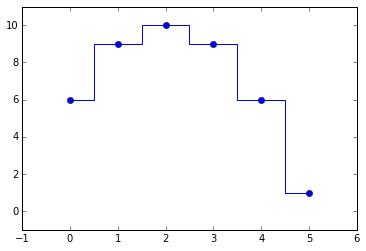

In [9]:
nx = 5 
x = np.linspace(0,5,6)
d = np.linspace(0,1,6)**2
h = 10-(x-2)**2
hu = np.linspace(0,0.5,6)**2
plt.step(x,h,'o',where='mid')
plt.xlim(-1,6)
plt.ylim(-1,11)

In [10]:
dl, dr, hl, hr, hul, hur   = getMusclReconstr(d,h,hu)

La figura izquierda muestra las rectas con pendientes calculadas con cada vecino. La segunda debería mostrar la pendiente MUSCL, que es cuando se elije la pendiente menos inclinada, o pendiente 0 si tienen signo diferente.

In [11]:
def check_muscl(x,h,hl,hr,ylim=0):
    plt.figure(figsize=(16,4))
    plt.subplot(121)
    plt.step(x,h,'ko',where='mid')
    for i in range(hl.shape[0]):
        s1 = h[i+1]-h[i]
        s2 = h[i+2]-h[i+1]   
        l1 = plt.plot([x[i+1]-0.5,x[i+1]+0.5],[h[i+1]-0.5*s1,h[i+1]+0.5*s1],'g')
        l2 = plt.plot([x[i+1]-0.5,x[i+1]+0.5],[h[i+1]-0.5*s2,h[i+1]+0.5*s2],'b')
#     plt.xlim(-1,6)
    if ylim!=0:
        plt.ylim(ylim)
    plt.title('s1,s2')

    plt.subplot(122)
    plt.step(x,h,'ko',where='mid')
    for i in range(hl.shape[0]):
        s1 = h[i+1]-h[i]
        s2 = h[i+2]-h[i+1]
        plt.plot([x[i+1]-0.5,x[i+1]+0.5],[hl[i],hr[i]],'r')
    if ylim!=0:
        plt.ylim(ylim)
    plt.title('minmod(s1,s2)')
    plt.legend(loc=0)
    # plt.ylim(-0.1,1.1)

/projects/sage/sage-6.9/local/lib/python2.7/site-packages/matplotlib-1.4.3-py2.7-linux-x86_64.egg/matplotlib/axes/_axes.py:475: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


(0, 12)

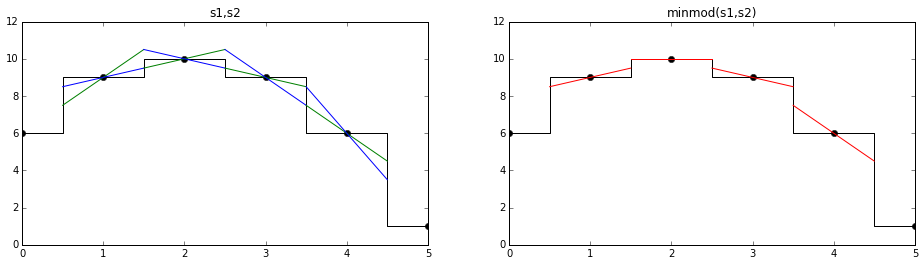

In [12]:
check_muscl(x,h,hl,hr,ylim=[0,12])
plt.ylim(0,12)

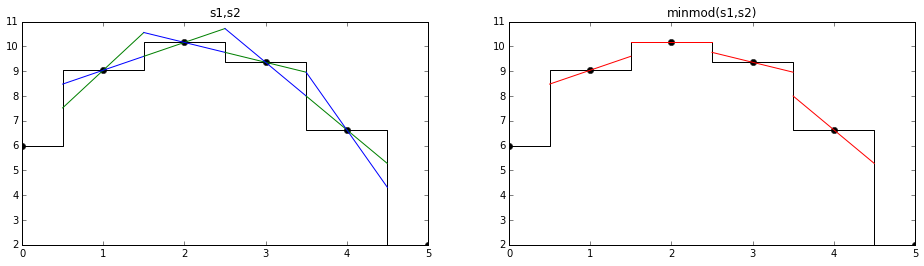

In [13]:
check_muscl(x,h+d,hl+dl,hr+dr)

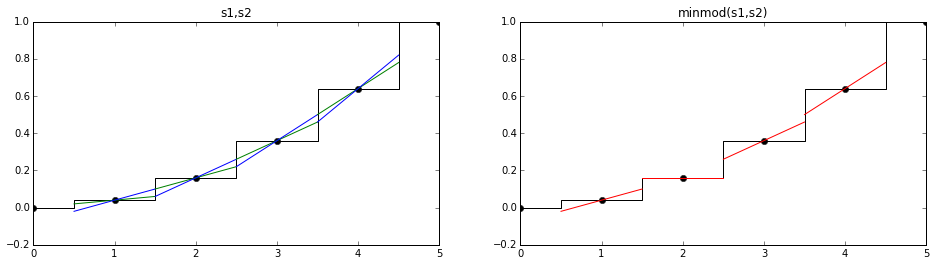

In [14]:
check_muscl(x,d,dl,dr)

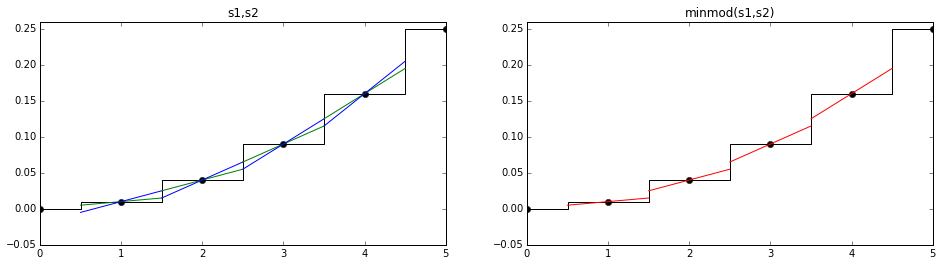

In [15]:
check_muscl(x,hu,hul,hur,ylim=[-0.05,0.26])

<a id="hydro"> </a>
## Reconstruccion hidrostatica

* Topografía en la interfaz se define como $$d_{i+1/2} = max(d_{i,r}, d_{i+1,l})$$
* Reconstruccoin de la altura del agua a cada lado de la interfaz queda 

$$h_{i+1/2-} = max(0, h_{i,r} +d_{i,r} - d_{i+1/2})$$
  $$h_{i+1/2+} = max(0, h_{i+1,l}+d_{i+1,l}-d_{i+1/2})$$
  
* Valores reconstruidos a cada lado de la interfaz

$$ U_{i+1/2-} = (h_{i+1/2-}, h_{i+1/2-} u_{i,r})^t$$
$$ U_{i+1/2+} = (h_{i+1/2+}, h_{i+1/2+} u_{i+1,l})^t$$

Funcion que retorna la batimetria reconstruida en cada interfaz y los vectores de variables reconstruidas a la izquierda (-) y derecha (+) de cada interfaz. Recibe los valores $U_{i,r}$ y $U_{i,l}$ y $d_{i,l}$ y $d_{i,r}$. 

Denuevo: 
* Enumerar las celdas del 0 al $n_x+3$ (2ghost por lado) ... dibujar para entender!
* Interesan los flujos + y - en $1+1/2$ ... $n_x+1+1/2$ (largo $n_x+1$, dos arreglos para los valores "más +" y los "menos -")
* para calcular $i+1/2^\pm$ se necesita $d_{i,r}, U_{i,r}$ y $d_{i+1,l}, U_{i+1,l}$ ($U=(h,hu))$)
* Para calcular los flujos necesitamos los $U_{il},U_{ir}$ con $i =1 ... n_x+2$ (se necesita el $U_{1r}$ y el $U_{(nx+2)l}$) (largo $n_x+2$)


In [16]:
#recibe dl,dr,hl,hr,hul,hur (nx-2, sigo el ejemplo de arriba)
#entrega valores plus minus de la reconstruccion hidrostatica
def getHydrReconstr(dl,dr,hl,hr,hul,hur):
    nx = dl.shape[0]-2
    dinter = np.zeros((nx+1))
    hp = np.zeros((nx+1,))
    hup = np.zeros((nx+1,))
    hm = np.zeros((nx+1,))
    hum = np.zeros((nx+1,))

    dinter = np.maximum(dr[:-1],dl[1:])
    hm = np.maximum(0., hr[:-1]+dr[:-1]-dinter)
    hp = np.maximum(0., hl[1:]+dl[1:]-dinter)
    hum = np.where(hr[:-1]>0,hm*hur[:-1]/hr[:-1],0.)
    hup = np.where(hl[1:]>0,hp*hul[1:]/hl[1:],0.)
    
    return dinter, hm, hp, hum, hup


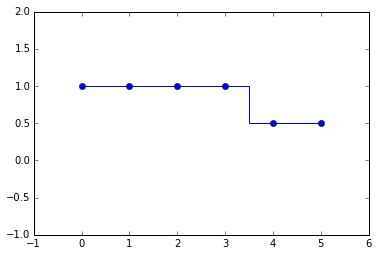

In [17]:
nx = 5 
x = np.linspace(0,5,6)
d = np.linspace(0,0,6)**2
h = np.where(x<=3,1.,0.5)
hu = np.zeros_like(h)
plt.step(x,h,'o',where='mid')
plt.xlim(-1,6)
plt.ylim(-1,2)
dl, dr, hl, hr, hul, hur   = getMusclReconstr(d,h,hu)

In [18]:
dinter,hm, hp, hum, hup = getHydrReconstr(dl,dr,hl,hr,hul,hur)

(-1, 2)

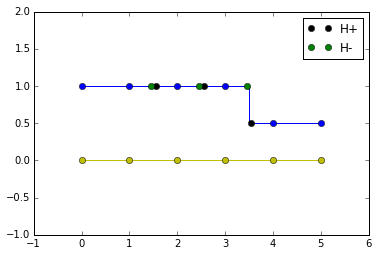

In [19]:
plt.step(x,h+d,'o',where='mid')
plt.step(x,d,'yo',where='mid')
plt.plot(x[2:-1]-0.45,hp+dinter,'ko',label='H+')
plt.plot(x[1:-2]+0.45,hm+dinter,'go',label='H-')
plt.legend(loc=0)
plt.xlim(-1,6)
plt.ylim(-1,2)

Notar que ```hp[0]``` es de $h_{1+1/2^+}$ y ```hm[0]``` es $h_{1+1/2^-}$

(-0.025, 0.05)

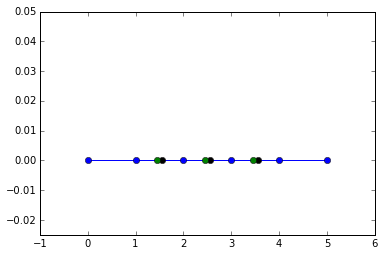

In [20]:
plt.step(x,hu,'o',where='mid')
plt.plot(x[2:-1]-0.45,hup,'ko',label='hu+')
plt.plot(x[1:-2]+0.45,hum,'go',label='hu-')
plt.xlim(-1,6)
plt.ylim(-.025,0.05)

Se ve decente.

<a id="flux"></a>
## Calcular términos fuente y flujos en las interfaces

Usando los valores de flujo en interfaz se calcula

$$F_{i+1/2}^- = F^*_{i+1/2} + S_{i+1/2-}$$
$$F_{i+1/2}^+ = F^*_{i+1/2} + S_{i+1/2+}$$

donde $$F^*_{i+1/2} = \mathcal{F}(U^*_{i+1/2}(0, U_{i+1/2-}, U_{i+1/2+})$$ con $U^*(t,U_l,U_r)$ el operador que resuelve el problema de Riemann homogeneo para un $t$ dado entre $U_l$ y $U_r$; $\mathcal{F}(U)$ es la funcion de flujo de interfaz.

y ademas

$$S_{i+1/2-} = \left(0, \frac{g}{2}(h_{i+1/2-}^2 -h_{i,r}^2)\right)^t$$
$$S_{i-1/2+} = \left(0, \frac{g}{2}(h_{i,l}^2 -h_{i-1/2+}^2)\right)^t$$

o mejor, poner el $i+1/2\pm$
$$S_{i+1/2+} = \left(0, \frac{g}{2}(h_{i+1,l}^2 -h_{i+1/2+}^2)\right)^t$$
$$S_{i+1/2-} = \left(0, \frac{g}{2}(h_{i+1/2-}^2 -h_{i,r}^2)\right)^t$$

El esquema semidiscreto queda

$$ \frac{d}{dt} U_{i}(t) + \frac{1}{\Delta x}(F_{i+1/2}^- - F_{i-1/2}^+) = S_{c,i}$$

donde $$S_{c,i} = \left( 0, g\frac{h_{i,l}+h_{i,r}}{2}(d_{i,l}-d_{i,r}) \right) $$

In [21]:
def sources(dl,dr,hl,hr,hp,hm):
    sp = np.zeros((2,hl[1:].shape[0]))
    sm = np.zeros((2,hm.shape[0]))
    sc = np.zeros((2,dl.shape[0]))
    sp[1,:] = 0.5*g*(hl[1:]**2-hp**2)    
    sm[1,:] = 0.5*g*(hm**2-hr[:-1]**2)    
    sc[1,:] = 0.5*g*(hl+hr)*(dl-dr)
    return sp, sm, sc

In [22]:
sp, sm, sc = sources(dl,dr,hl,hr,hp,hm)

In [23]:
sc

array([[ 0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.]])

In [24]:
def flux(h,u):
    return np.array([h*u, 0.5*g*h**2 + h*u**2])

Recordar

$F_{i+1/2}^- = F^*_{i+1/2} + S_{i+1/2-}$

$F_{i+1/2}^+ = F^*_{i+1/2} + S_{i+1/2+}$

donde $F^*_{i+1/2} = \mathcal{F}(U^*_{i+1/2}(0, U_{i+1/2-}, U_{i+1/2+})$ 

con $U^*(t,U_l,U_r)$ el operador que resuelve el problema de Riemann homogeneo para un $t$ dado entre $U_l$ y $U_r$; $\mathcal{F}(U)$ es la funcion de flujo de interfaz.

y ademas

$$ \frac{d}{dt} U_{i}(t) + \frac{1}{\Delta x}(F_{i+1/2}^- - F_{i-1/2}^+) = S_{c,i}$$

donde $$S_{c,i} = \left( 0, g\frac{h_{i,l}+h_{i,r}}{2}(d_{i,l}-d_{i,r}) \right) $$


In [25]:
def fluxes_sources(d,h,hu,n):
    """
        Calcula los flujos en cada interfaz,
        Tambien entrega el termino fuente centrado
        de la reconstruccion hidrostatica
        Retorna:
        
        fp: F_{i+1/2^+} de 2xninterfaces=2x(nx+1)
        fm: F_{i+1/2^-} de 2xninterfaces=2x(nx+1)
        sc: 
        ninterfaces = nx+1: (indice 0), desde 1+1/2...nx+1/2
        
    """
    nx = d.shape[0]-4
    fs = np.zeros((2,nx+1))
    fp = np.zeros((2,nx+1))
    fm = np.zeros((2,nx+1))
    
    dl, dr, hl, hr, hul, hur = getMusclReconstr(d,h[n,:],hu[n,:])
    
    dinter, hm, hp, hum, hup = getHydrReconstr(dl,dr,hl,hr,hul,hur)
    sp, sm, sc = sources(dl,dr,hl,hr,hp,hm)
    
    #ahora calcular los flujos estrella
    for i in range(nx+1):        
        hs,us = roe(hm[i],hum[i],hp[i],hup[i])
        fs[:,i] = flux(hs,us)
        
    #calculate fp and fm
    fp = fs + sp
    fm = fs + sm
    
    return fp, fm, sc

para el debugueo

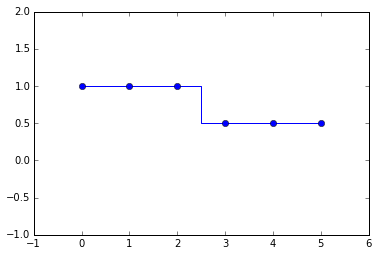

In [26]:
nx = 2
x = np.linspace(0,5,nx+4)
d = np.linspace(0,0,nx+4)**2
h = np.where(x<=2,1.,0.5)
hu = np.zeros_like(h)
plt.step(x,h,'o',where='mid')
plt.xlim(-1,6)
plt.ylim(-1,2)
dl, dr, hl, hr, hul, hur   = getMusclReconstr(d,h,hu)
dinter, hm, hp, hum, hup = getHydrReconstr(dl,dr,hl,hr,hul,hur)
sp, sm, sc = sources(dl,dr,hl,hr,hp,hm)
fs = np.zeros((2,hm.shape[0]))

#ahora calcular los flujos estrella
for i in range(nx+1):        
    hs,us = roe(hm[i],hum[i],hp[i],hup[i])
    fs[:,i] = flux(hs,us)
        
#calculate fp and fm
fp = fs + sp
fm = fs + sm   

In [27]:
fp[1:]-fm[:-1]

array([[ 4.905     ,  2.54829823,  1.22625   ]])

In [28]:
fs

array([[ 0.        ,  0.66835193,  0.        ],
       [ 4.905     ,  3.21665016,  1.22625   ]])

<a id="bcs"> </a>
## Función para las condiciones de borde

In [29]:
def bcs_cerrado(d,h,hu,n):
    """ 
        recibe las matrices y coloca los valores 
        correspondientes a la celda cerrada.
        
        Este es el tipico borde cerrado.
        
        No estoy seguro
        si modificar h,hu aqui dentro
        hace que se modifique fuera,
        asi que uso hb,hub
    """
    db = 1.*d
    hb = 1.*h
    hub = 1.*hu
    db[0] = db[3]
    db[1] = db[2]
    hb[n,0] = h[n,3]
    hb[n,1] = h[n,2]
    hub[n,0] = -hu[n,3]
    hub[n,1] = -hu[n,2]
    
    db[-1] = db[-4]
    db[-2] = db[-3]
    hb[n,-1] = h[n,-4]
    hb[n,-2] = h[n,-3]
    hub[n,-1] = -hu[n,-4]    
    hub[n,-2] = -hu[n,-3]    
    return db,hb,hub

In [30]:
def bcs_cerrado2(d,h,hu,n):
    """ 
        recibe las matrices y coloca los valores 
        correspondientes a la celda cerrada.
        
        Este es el tipico borde cerrado.
        
        No estoy seguro
        si modificar h,hu aqui dentro
        hace que se modifique fuera,
        asi que uso hb,hub
    """
    db = 1.*d
    hb = 1.*h
    hub = 1.*hu
    db[0] = db[2]
    db[1] = db[2]
    hb[n,0] = h[n,2]
    hb[n,1] = h[n,2]
    hub[n,0] = -hu[n,2]
    hub[n,1] = -hu[n,2]
    
    db[-1] = db[-3]
    db[-2] = db[-3]
    hb[n,-1] = h[n,-3]
    hb[n,-2] = h[n,-3]
    hub[n,-1] = -hu[n,-3]    
    hub[n,-2] = -hu[n,-3]    
    return db,hb,hub

<a id="setdt"></a>
## Función para determinar dt

In [31]:
def setdt(h,hu,n,dx,cfl):
    """
        Calcula el dt segun condicion de CFL
    """
    u_n = np.where(h[n,:]>1e-5, hu[n,:]/h[n,:], 0.)
    s = np.max(np.abs(u_n)+np.sqrt(9.81*h[n,:]))
    dt = cfl*dx/np.max(s)
    return dt

<a id="iterate"></a>
## Funcion para calcular las iteraciones

$$ \frac{d}{dt} U_{i}(t) + \frac{1}{\Delta x}(F_{i+1/2}^- - F_{i-1/2}^+) = S_{c,i}$$

Prueba chica para ver si al menos anda

(-1, 2)

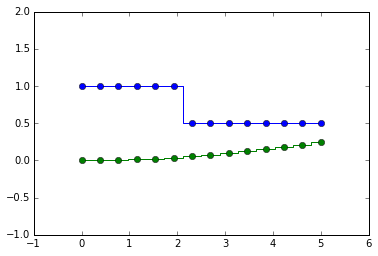

In [47]:
nx = 10
x = np.linspace(0,5,nx+4)
dx = np.diff(x)[0]

nt = 5
t = np.zeros((nt+1,))
cfl = 0.95

d = np.linspace(0,0.5,nx+4)**2
h = np.zeros((nt+1,nx+4))
hu = np.zeros((nt+1,nx+4))
h[0,:] = np.where(x<=2,1.-d,0.5-d)
hu[0,:] = 0.

hu = np.zeros_like(h)
plt.step(x,h[0,:]+d,'o',where='mid')
plt.step(x,d,'o',where='mid')
plt.xlim(-1,6)
plt.ylim(-1,2)

$$ \frac{d}{dt} U_{i}(t) + \frac{1}{\Delta x}(F_{i+1/2}^- - F_{i-1/2}^+) = S_{c,i}$$

In [48]:
for n in range(nt):
    d,h,hu = bcs_cerrado2(d,h,hu,n)    
    dt = setdt(h,hu,n,dx,cfl)
    t[n+1] = t[n] + dt
    fp,fm,sc = fluxes_sources(d,h,hu,n)
    h[n+1,2:-2] = h[n,2:-2] -dt/dx*(fm[0,1:] - fp[0,:-1]) + sc[0,1:-1]
    hu[n+1,2:-2] = hu[n,2:-2] -dt/dx*(fm[1,1:] - fp[1,:-1]) + sc[1,1:-1]

In [49]:
d

array([ 0.00591716,  0.00591716,  0.00591716,  0.01331361,  0.02366864,
        0.03698225,  0.05325444,  0.07248521,  0.09467456,  0.11982249,
        0.14792899,  0.17899408,  0.17899408,  0.17899408])

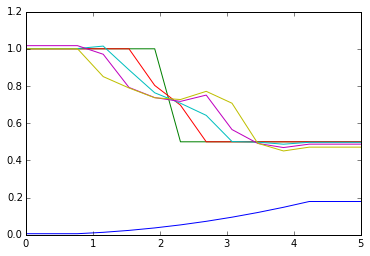

In [50]:
plt.plot(x,d)
plt.plot(x,h[0,:]+d)
plt.plot(x,h[1,:]+d)
plt.plot(x,h[2,:]+d)
plt.plot(x,h[3,:]+d)
plt.plot(x,h[4,:]+d)

Funciona!!. La funcion principal queda entonces

In [51]:
def simulate(d,h,hu,bcs,dx,cfl,t0,nt):
    """
        Rutina principal que corre la simulacion
    """
    t = np.zeros((nt,))
    for n in range(nt-1):     
        dt = setdt(h,hu,n,dx,cfl)
        
        t[n+1] = t[n] + dt

        d,h,hu = bcs(d,h,hu,n)    
        fp,fm,sc = fluxes_sources(d,h,hu,n)

        h[n+1,2:-2] = h[n,2:-2] -dt/dx*(fm[0,1:] - fp[0,:-1]) + sc[0,1:-1]
        hu[n+1,2:-2] = hu[n,2:-2] -dt/dx*(fm[1,1:] - fp[1,:-1]) + sc[1,1:-1]
    return t,h,hu

<a id="case1"></a>
# Caso 1: rompimiento de presa, canal horizontal, fondo mojado

<a id="c1-data"></a>
## Datos

In [82]:
nx = 100
x = np.linspace(0,5,nx+4)
dx = np.diff(x)[0]

nt = 200
t = np.zeros((nt+1,))
t0 = 00.
cfl = 0.45

(-1, 2)

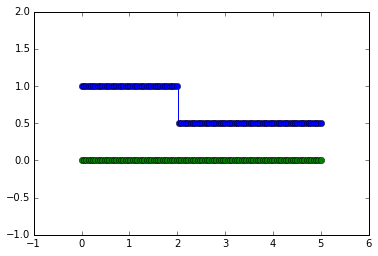

In [83]:
d = np.linspace(0,0.,nx+4)**2
h = np.zeros((nt+1,nx+4))
hu = np.zeros((nt+1,nx+4))
h[0,:] = np.where(x<=2,1.-d,.5)
hu[0,:] = 0.

hu = np.zeros_like(h)
plt.step(x,h[0,:]+d,'o',where='mid')
plt.step(x,d,'o',where='mid')
plt.xlim(-1,6)
plt.ylim(-1,2)

<a id="c1-sim"></a>
## Simulacion

$$ \frac{d}{dt} U_{i}(t) + \frac{1}{\Delta x}(F_{i+1/2}^- - F_{i-1/2}^+) = S_{c,i}$$

In [84]:
t,h,hu = simulate(d,h,hu,bcs_cerrado2,dx,cfl,t0,nt);

/projects/sage/sage-6.9/local/lib/python2.7/site-packages/ipykernel/__main__.py:5: RuntimeWarning: invalid value encountered in divide


<a id="c1-vis"></a>
## Visualización preliminar

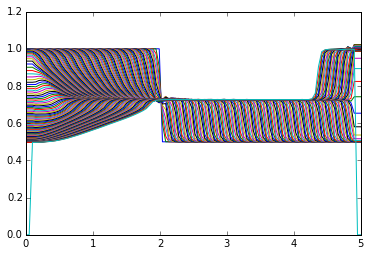

In [85]:
plt.plot(x,h[::1,:].T);

## Animacion javascript


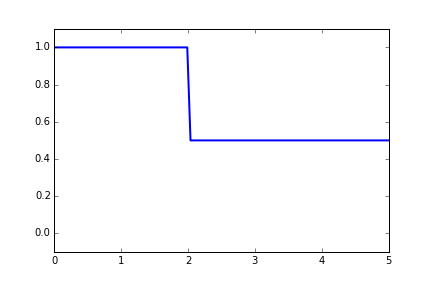
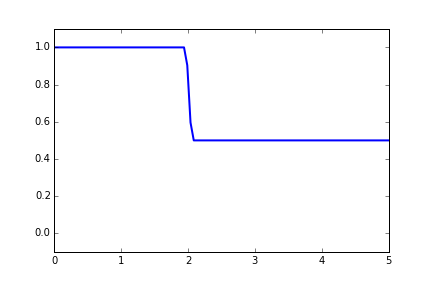
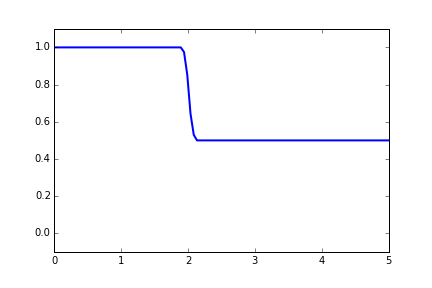
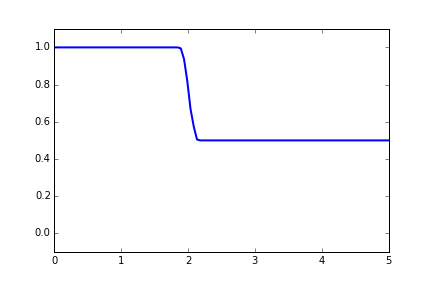
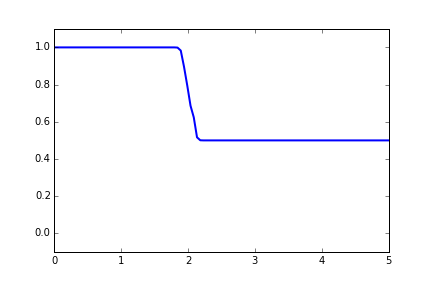
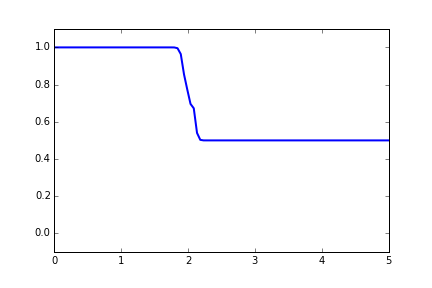
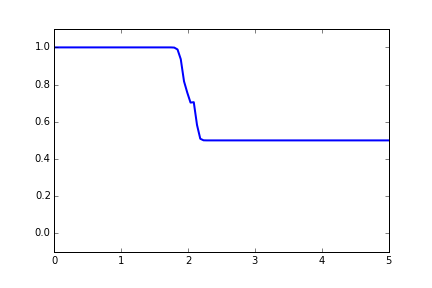
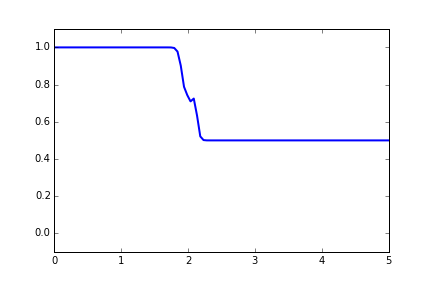
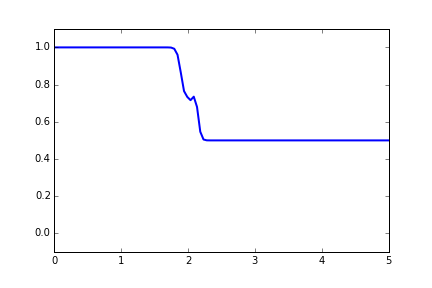
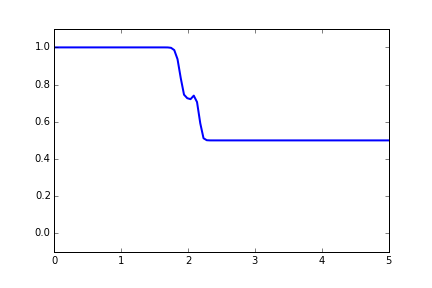
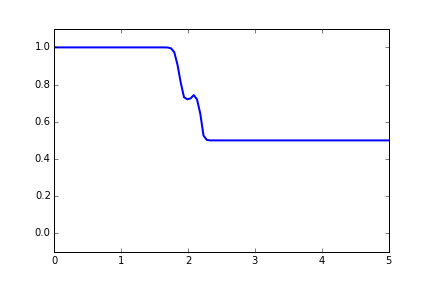
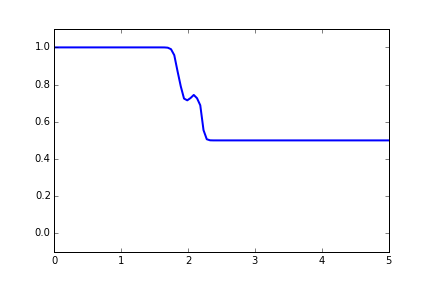
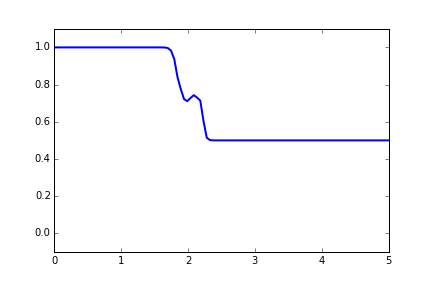
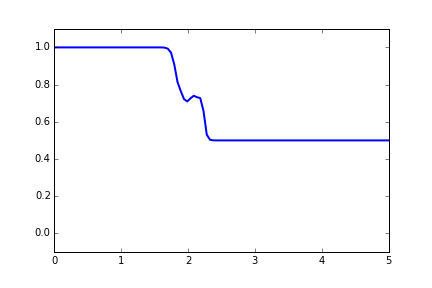
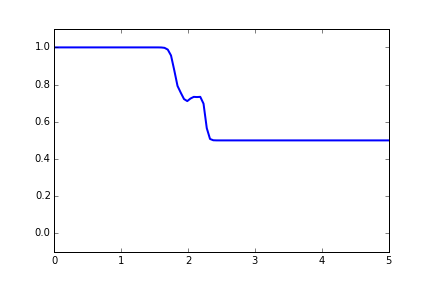
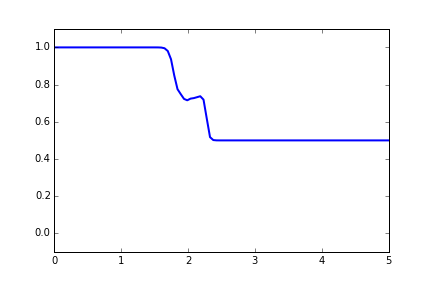
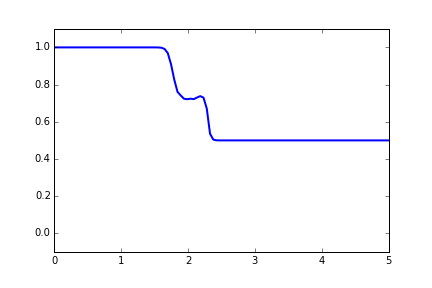
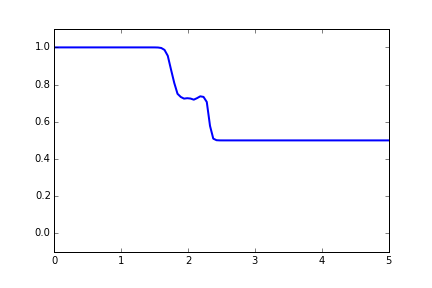
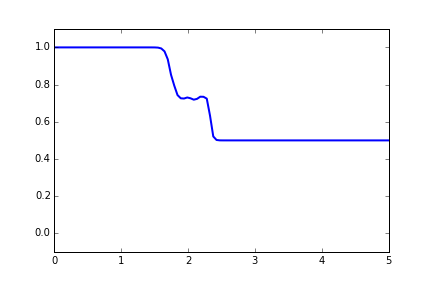
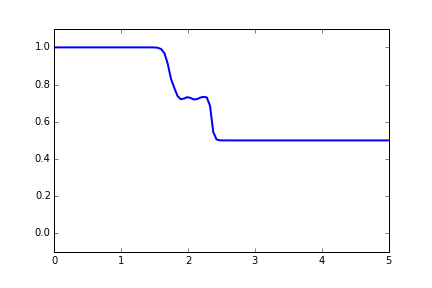
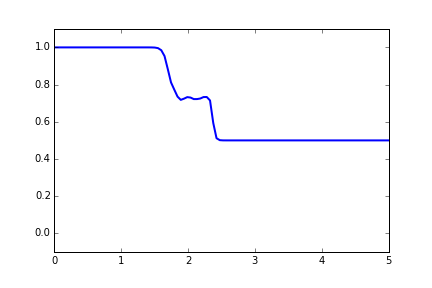
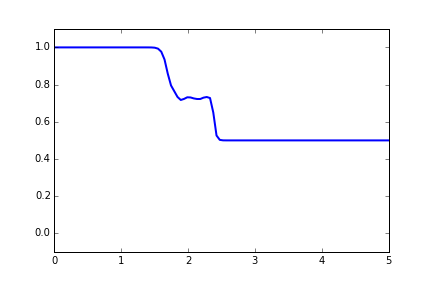
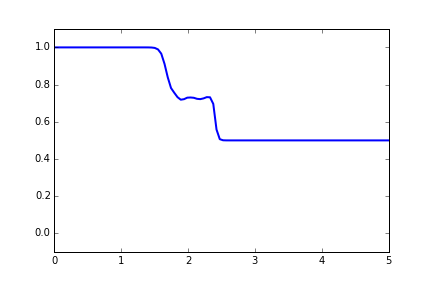
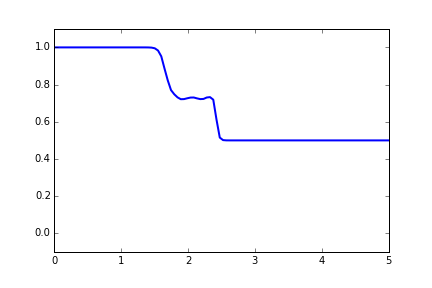
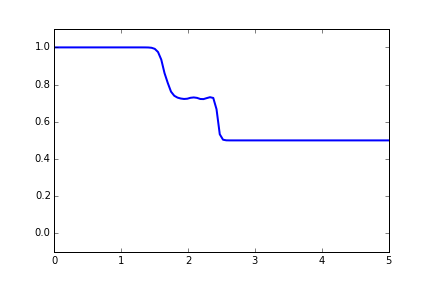
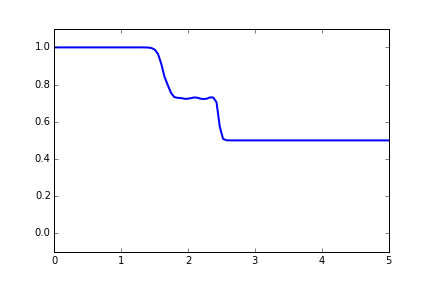
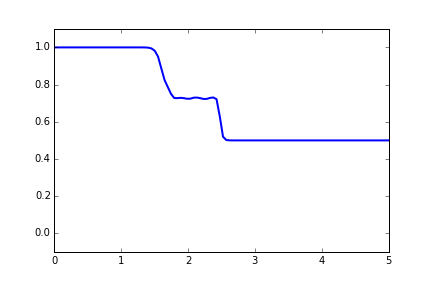
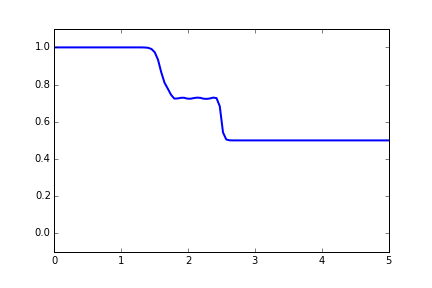
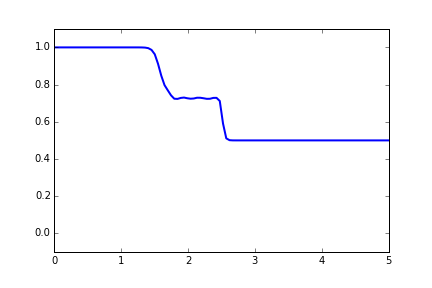
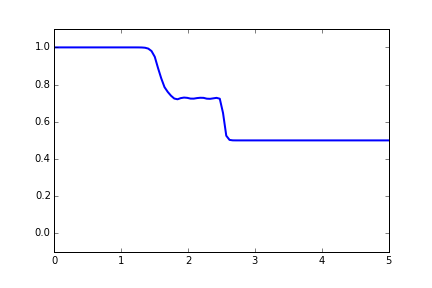
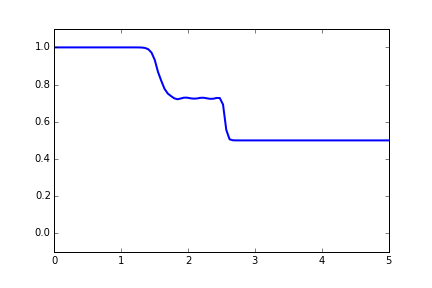
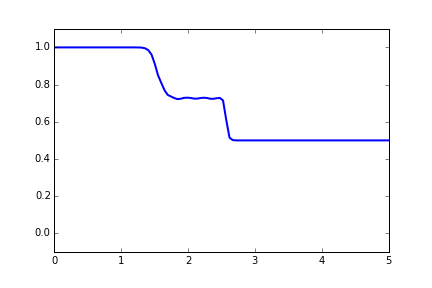
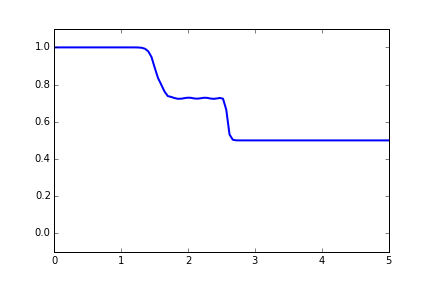
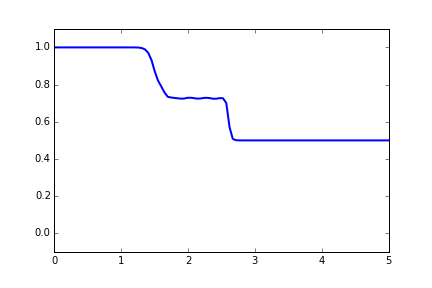
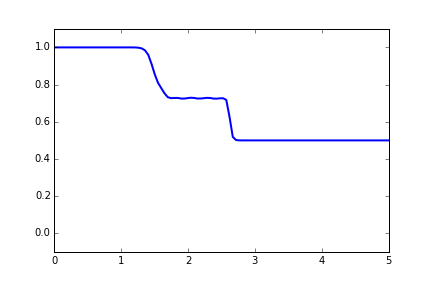
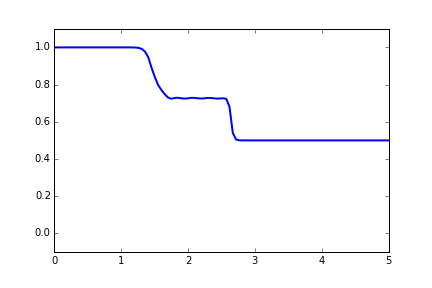
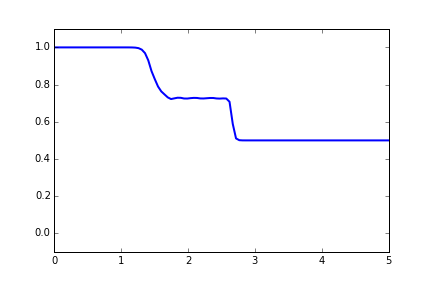
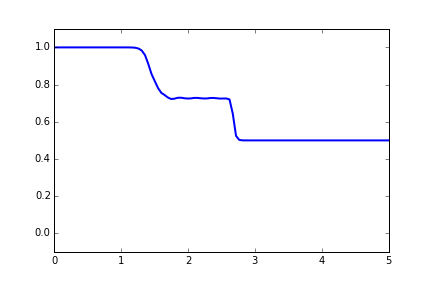
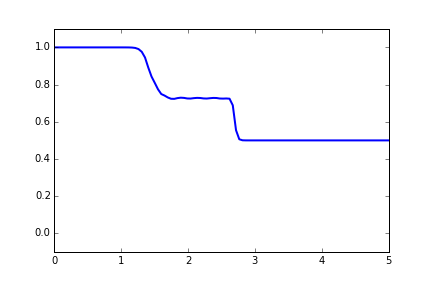
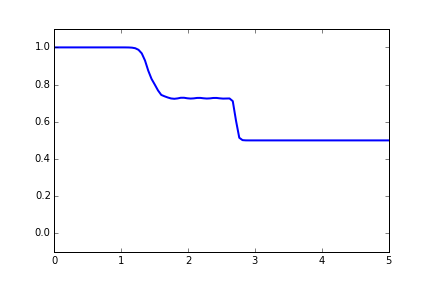
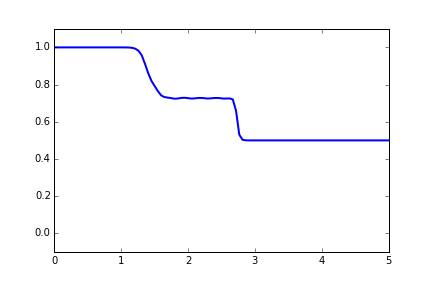
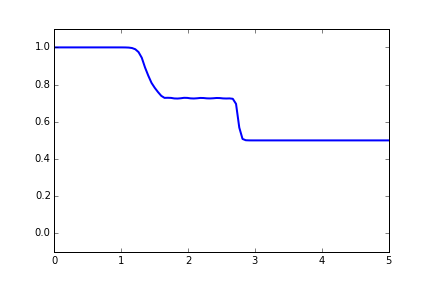
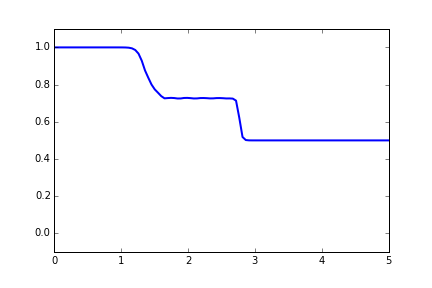
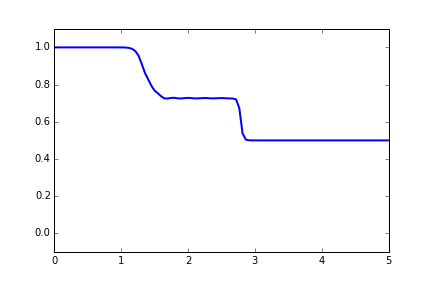
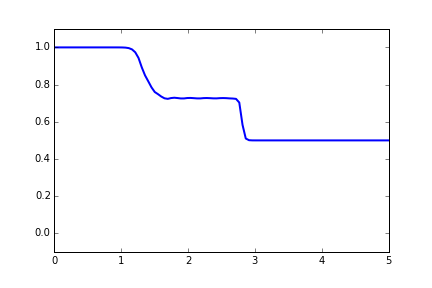
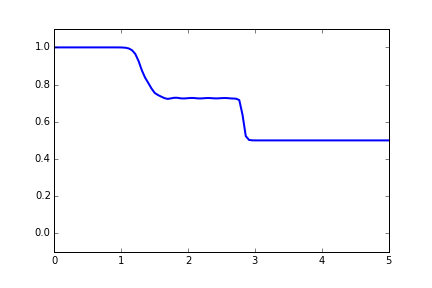
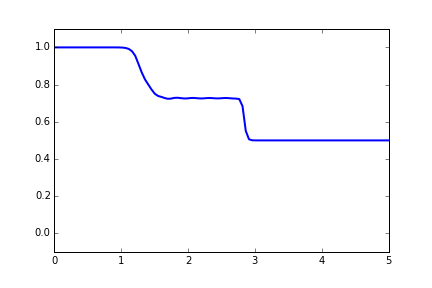
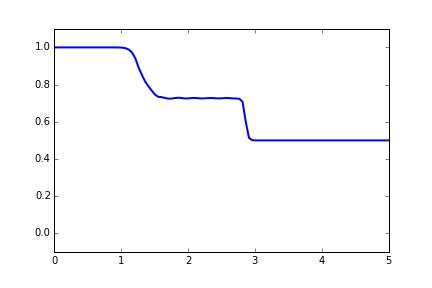
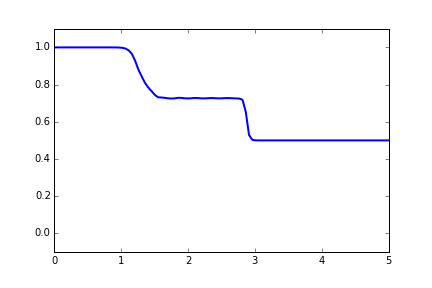
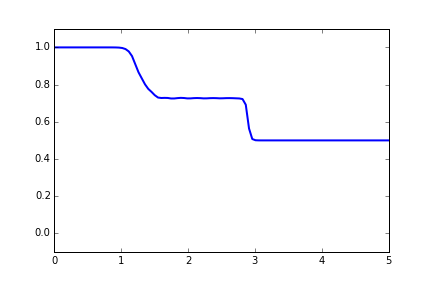
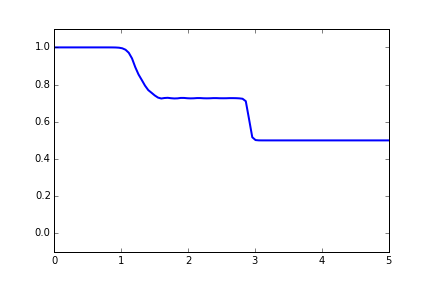
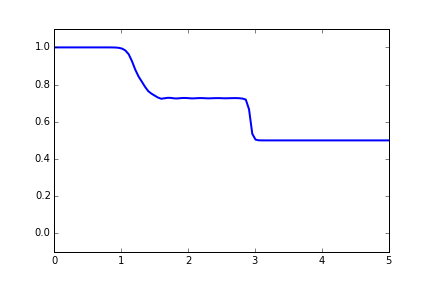
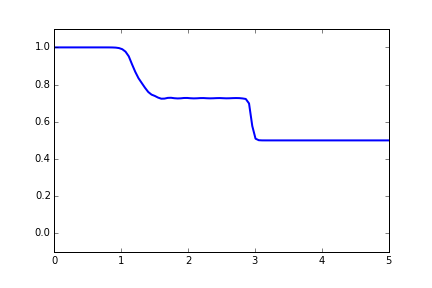
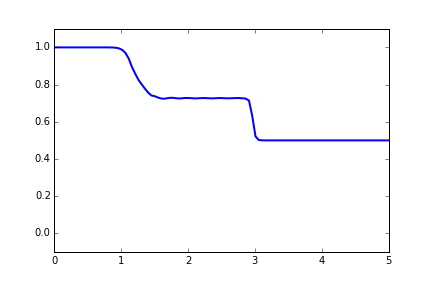
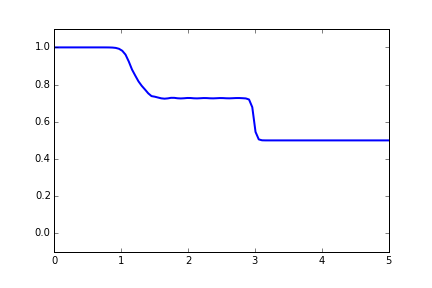
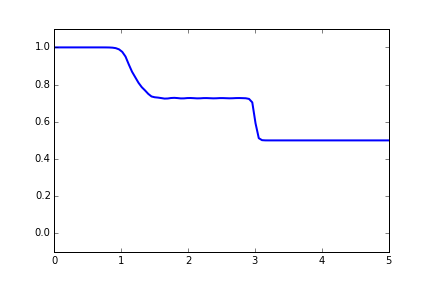
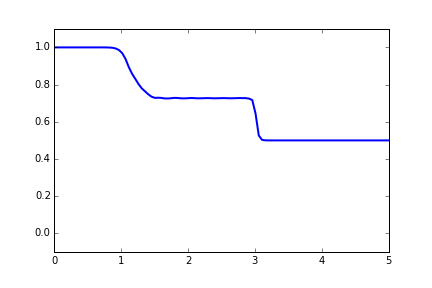
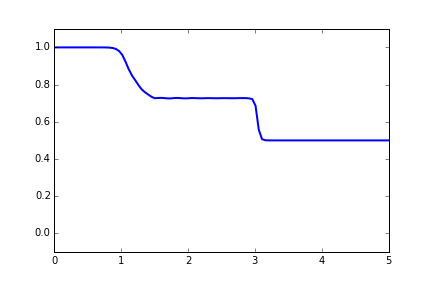
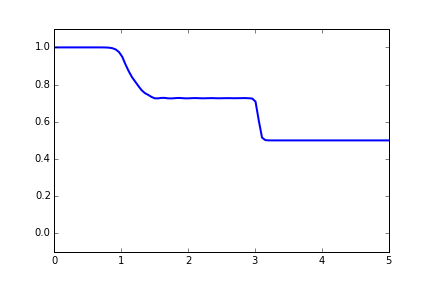
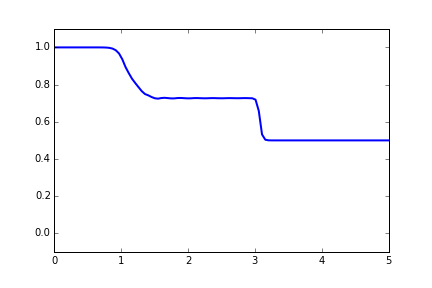
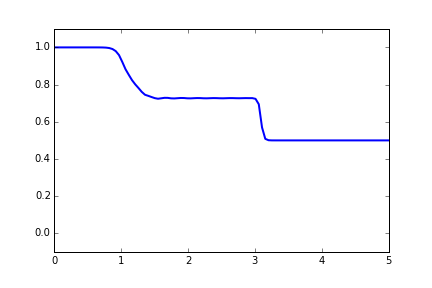
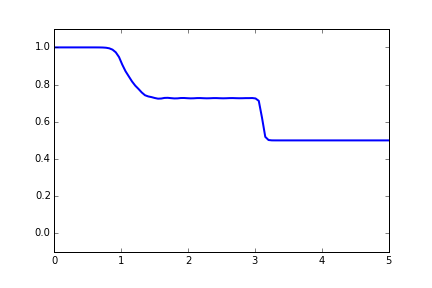
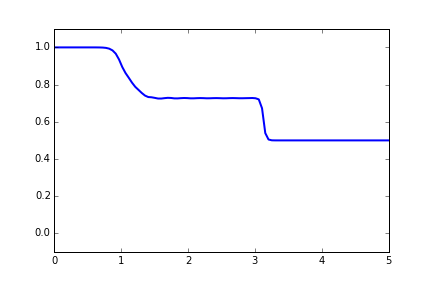
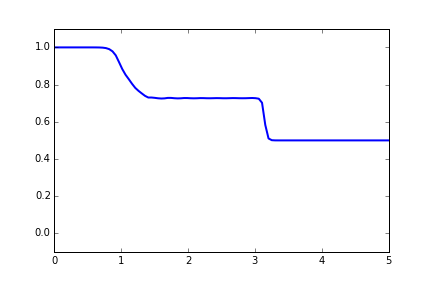
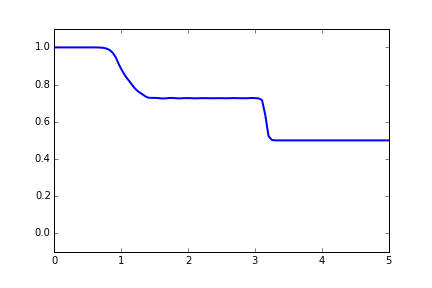
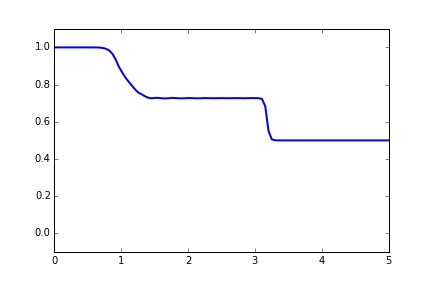
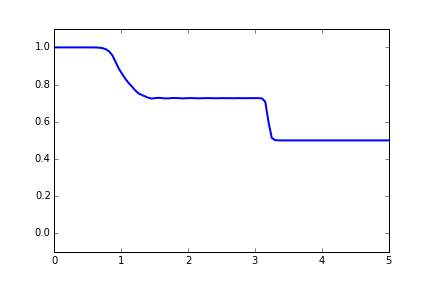
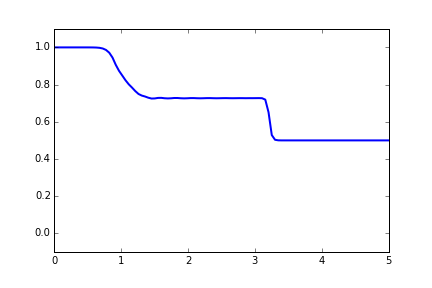
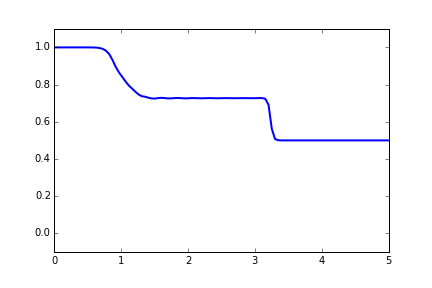
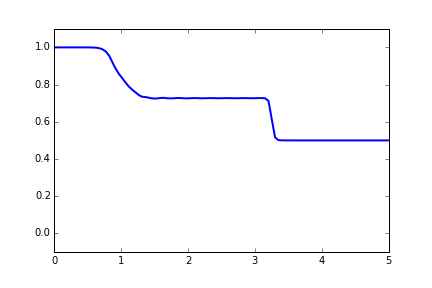
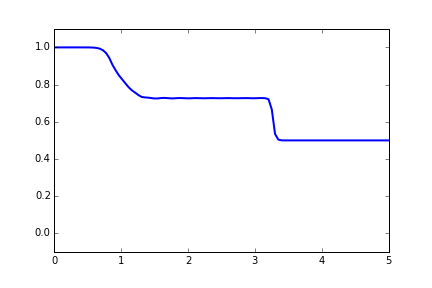
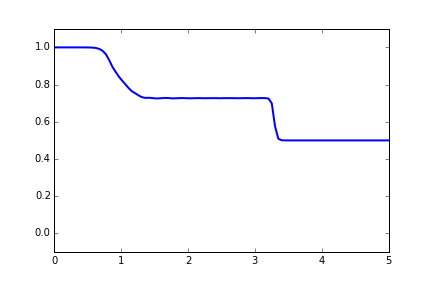
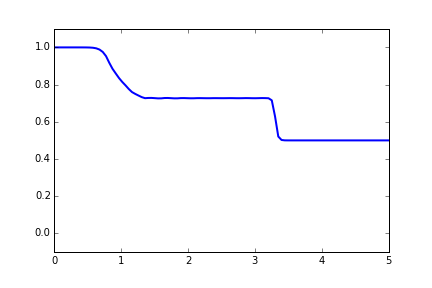
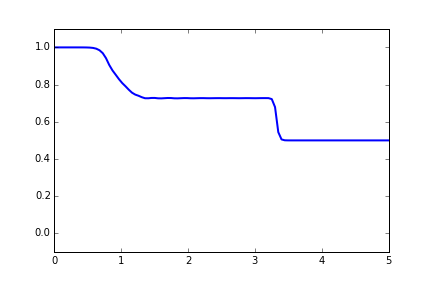
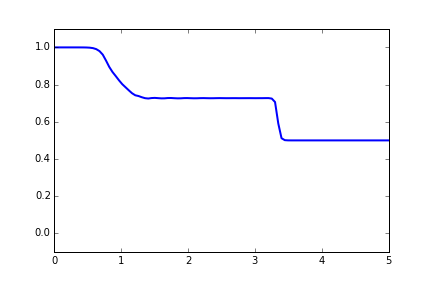
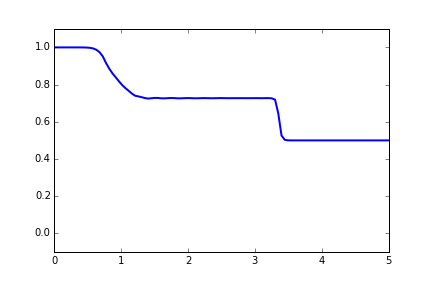
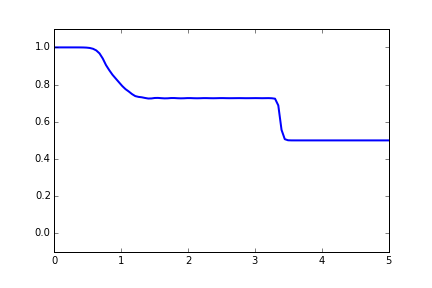
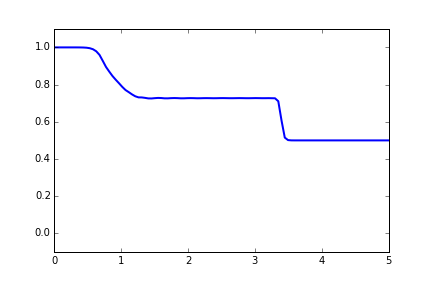
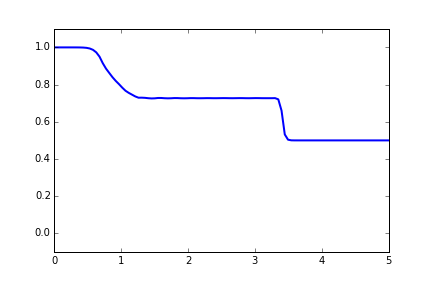
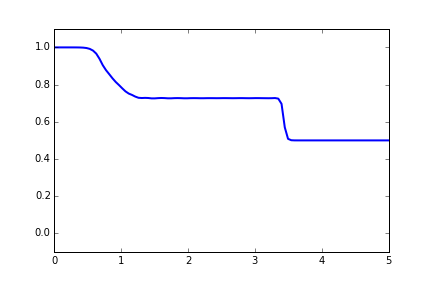
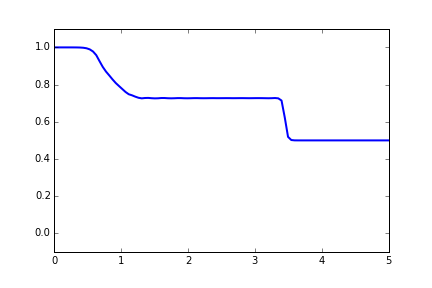
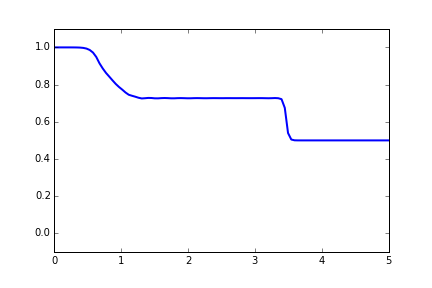
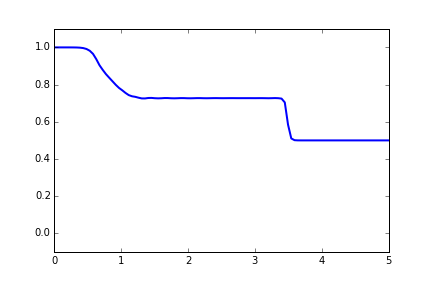
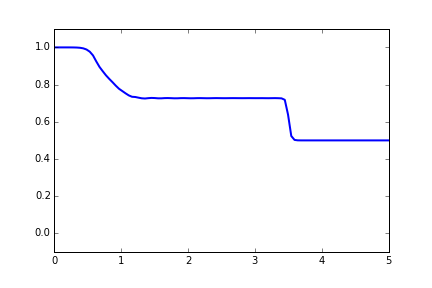
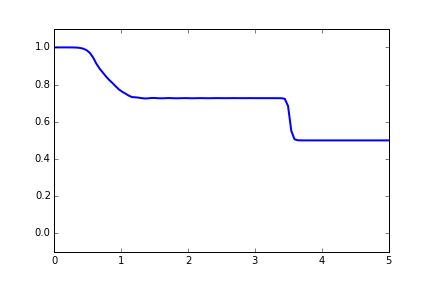
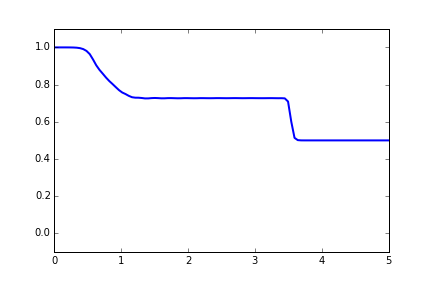
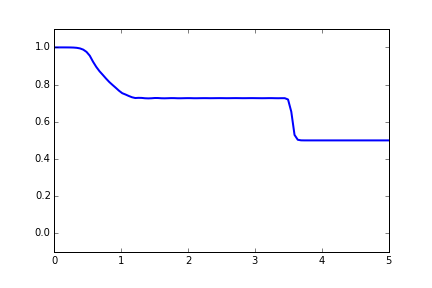
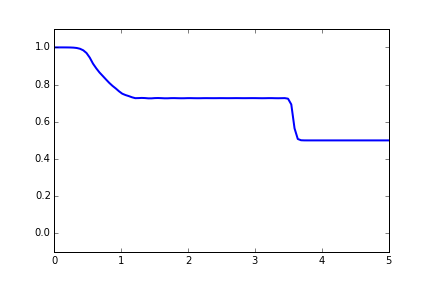
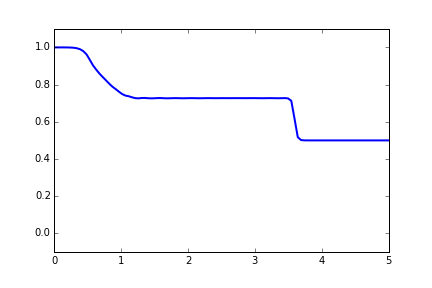
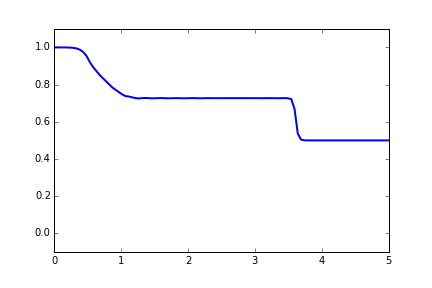
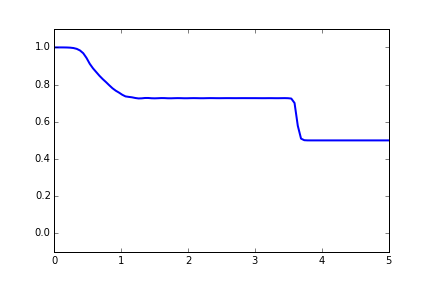
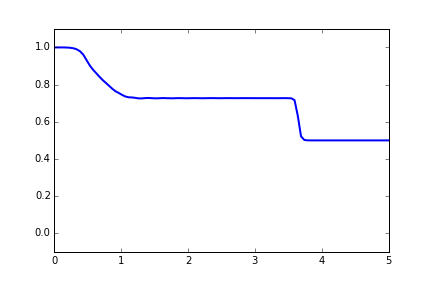
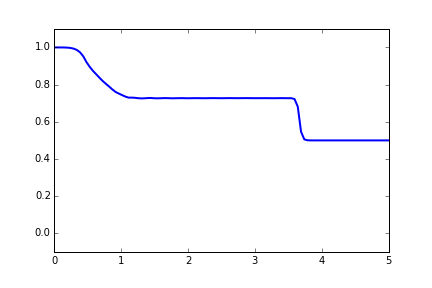
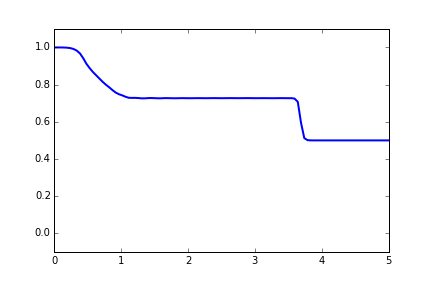
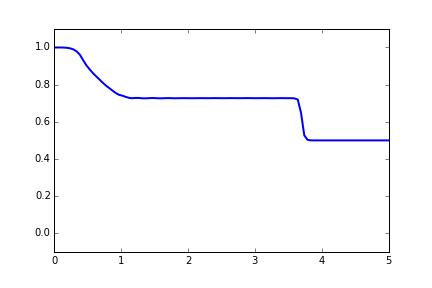
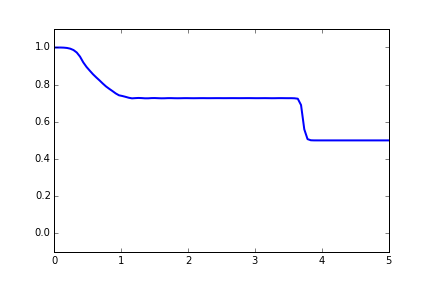
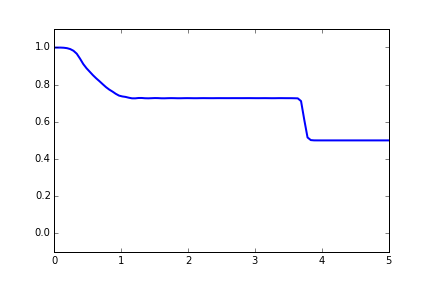
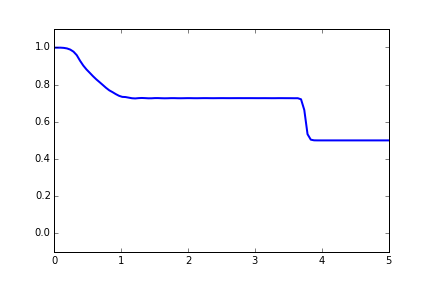
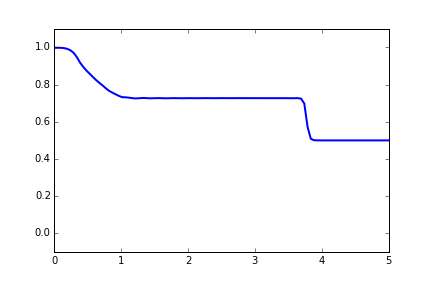
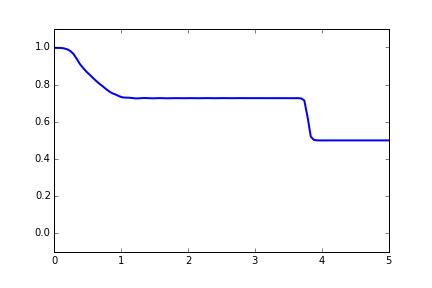
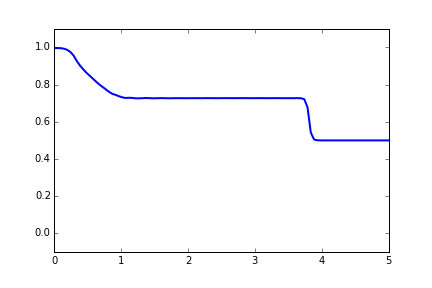
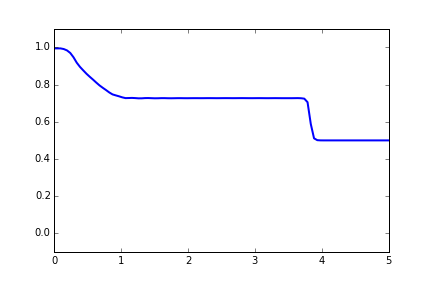
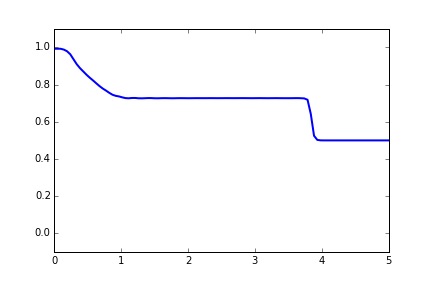
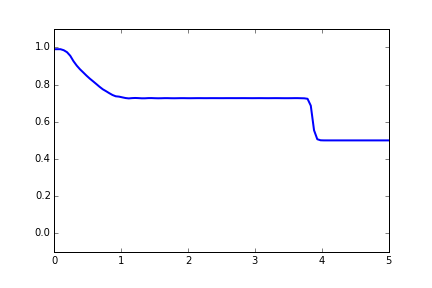
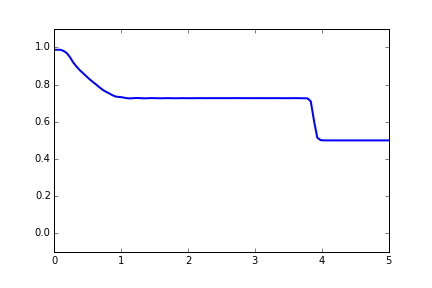
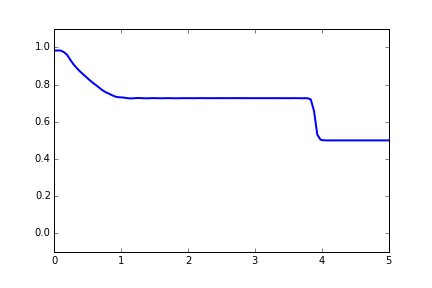
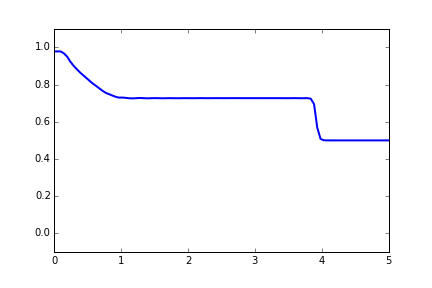
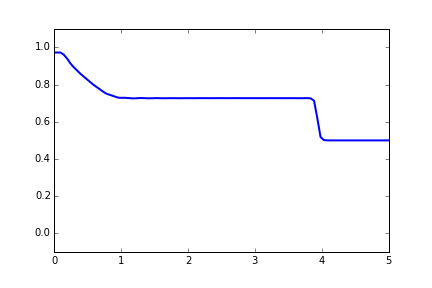
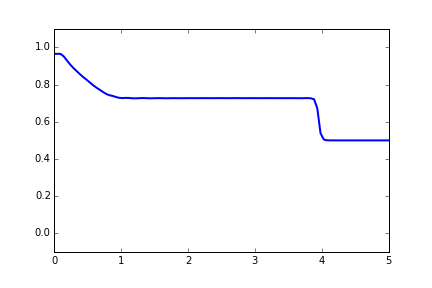
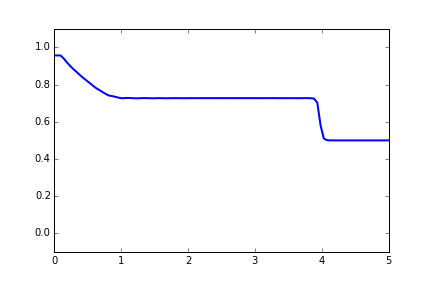
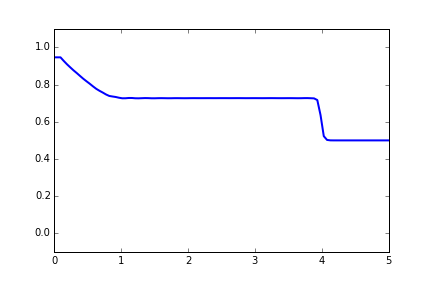
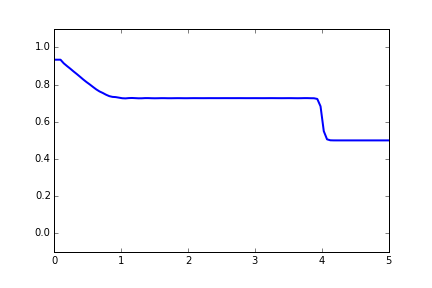
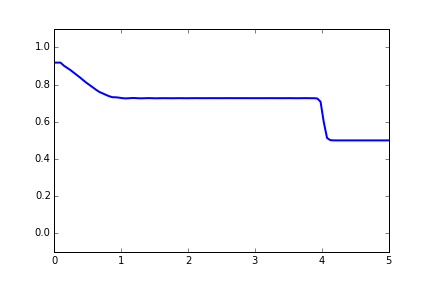
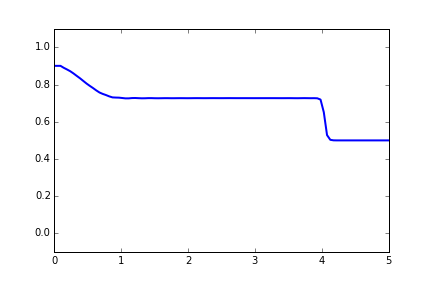
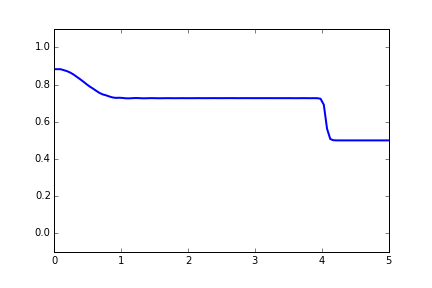
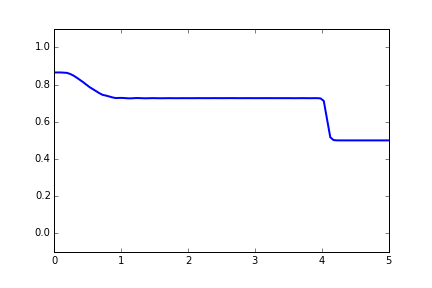
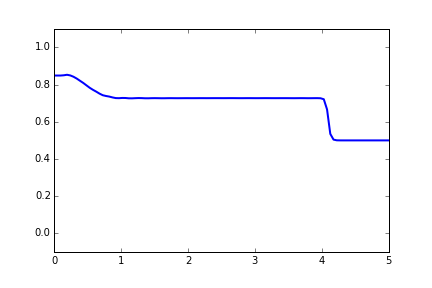
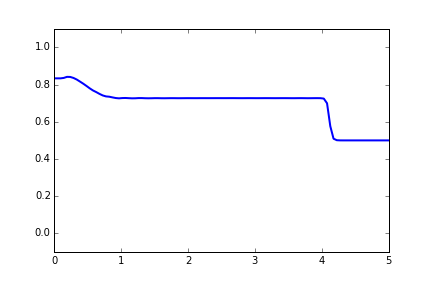
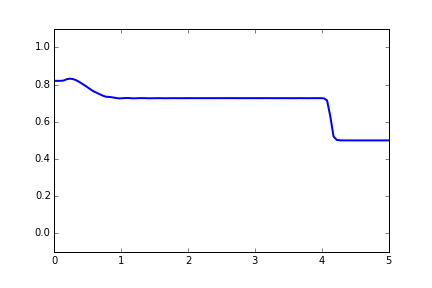
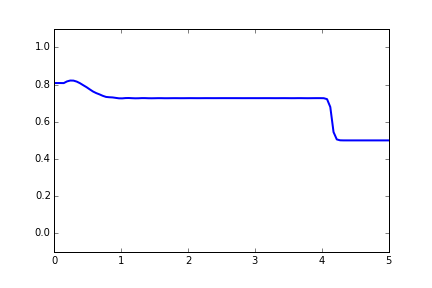
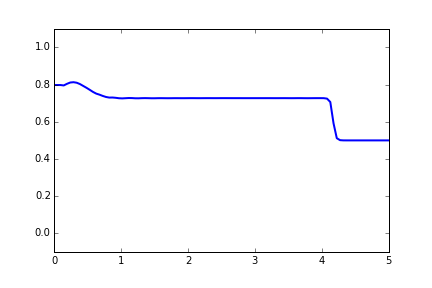
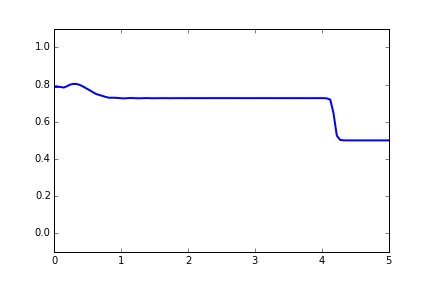
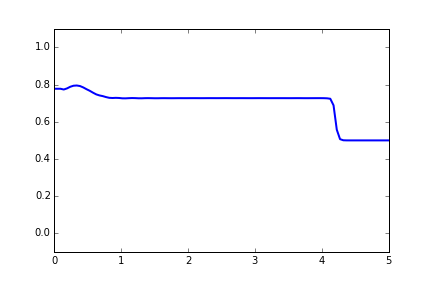
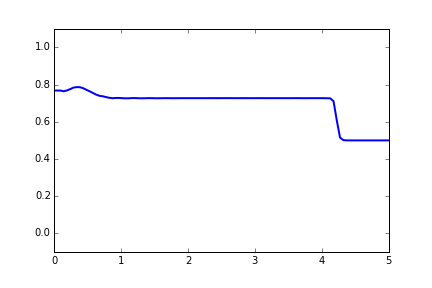
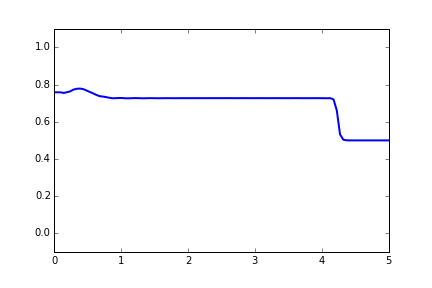
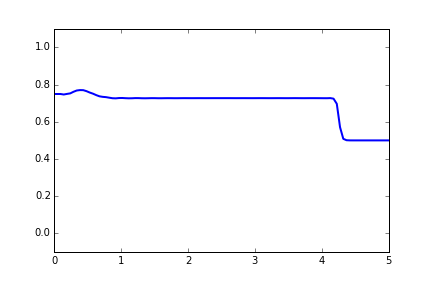
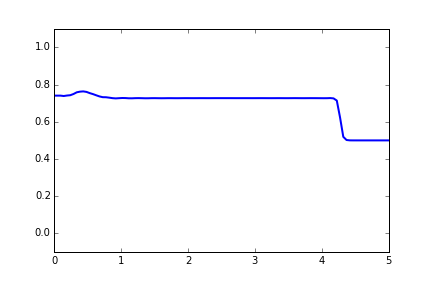
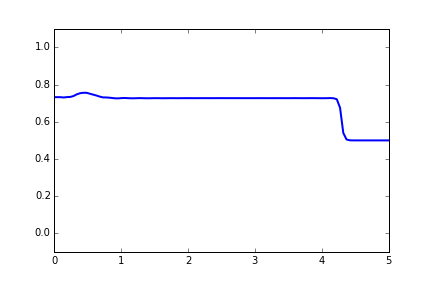
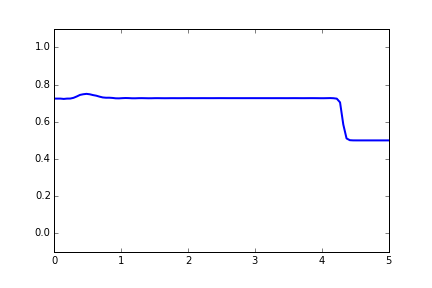
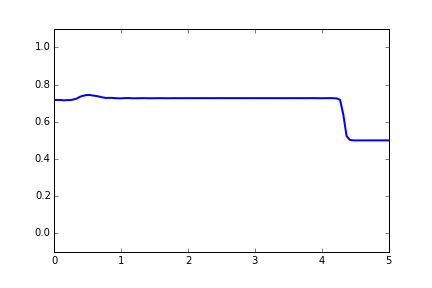
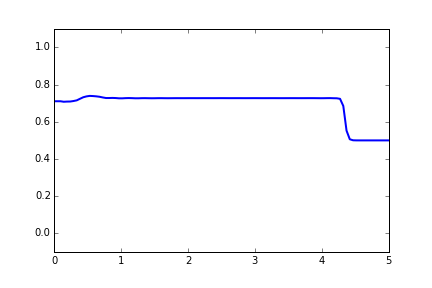
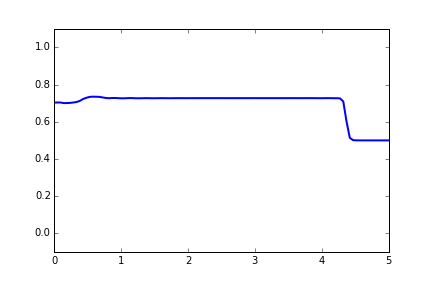
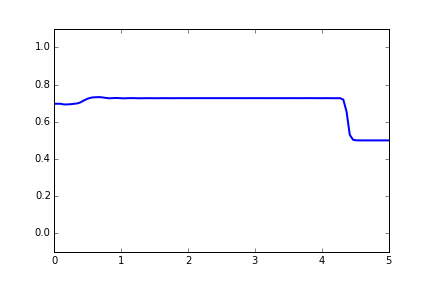
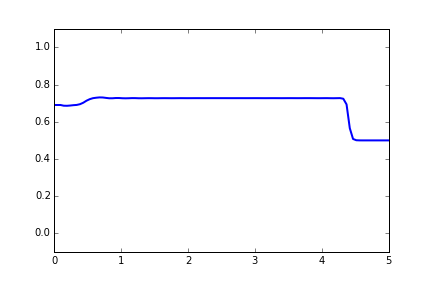
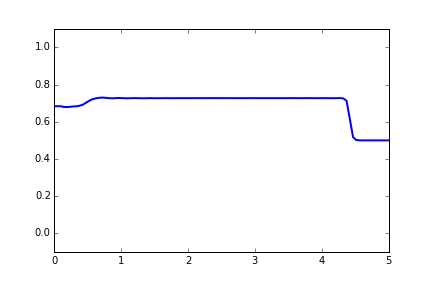
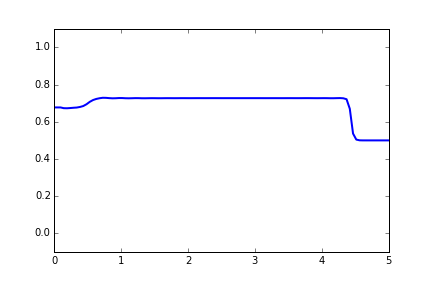
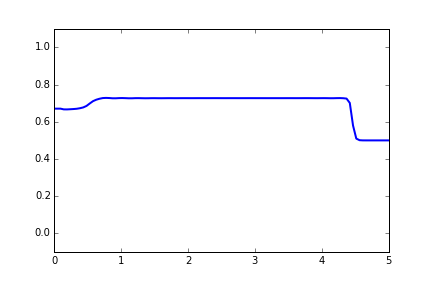
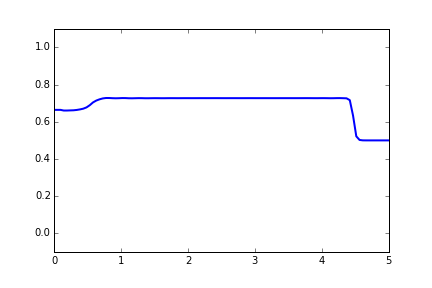
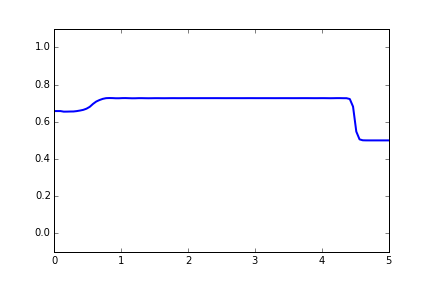
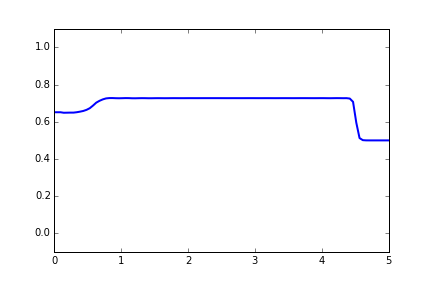
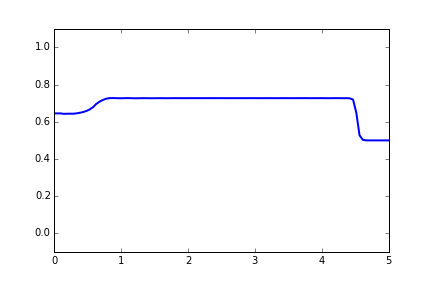
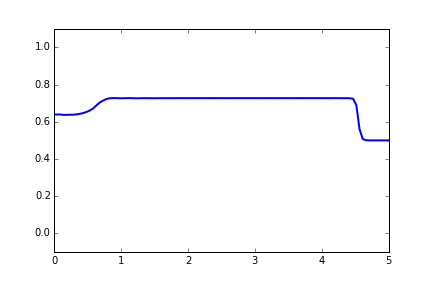
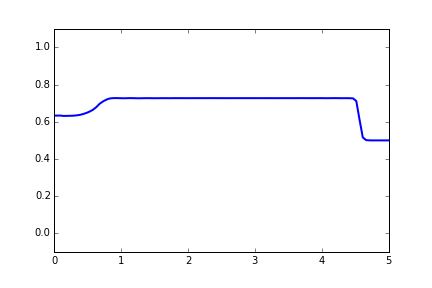
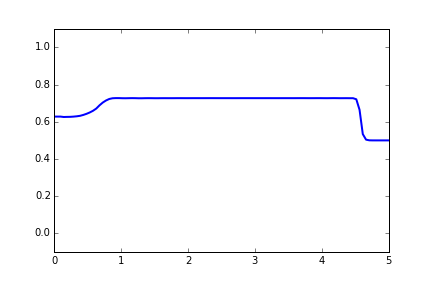
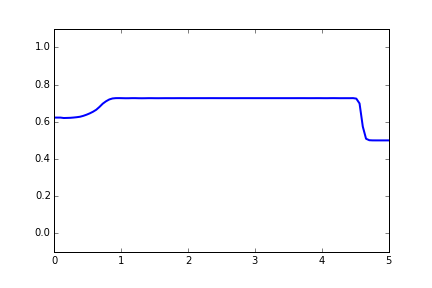
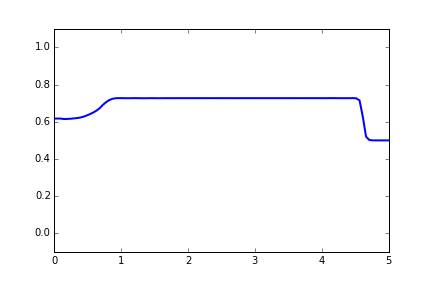
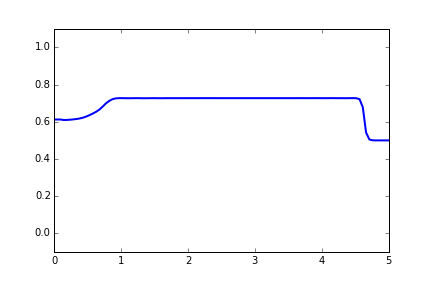
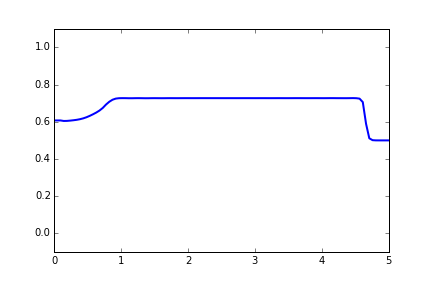
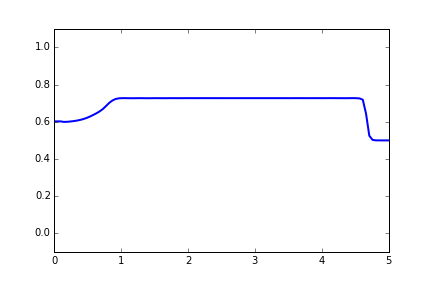
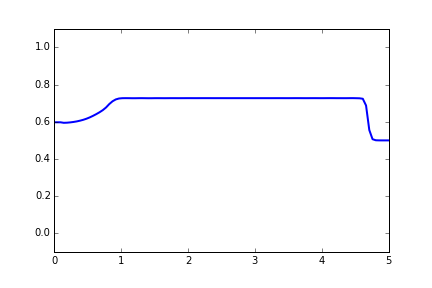
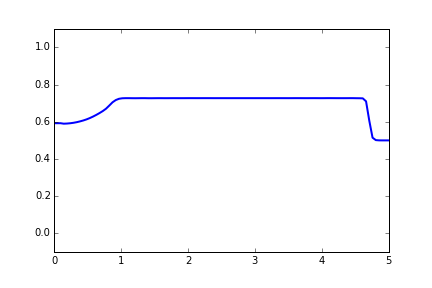
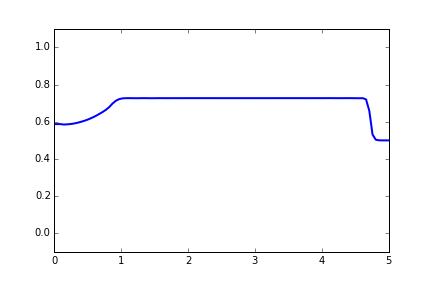
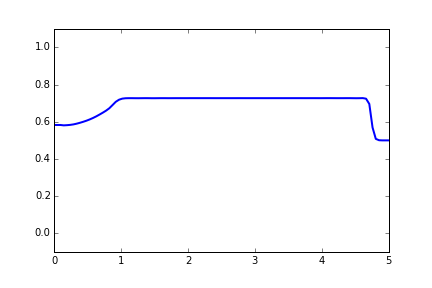
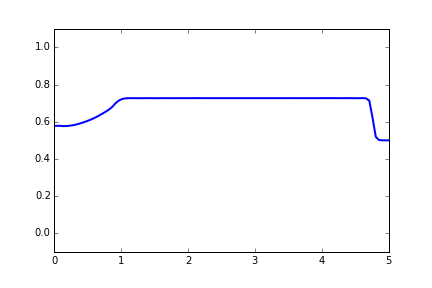
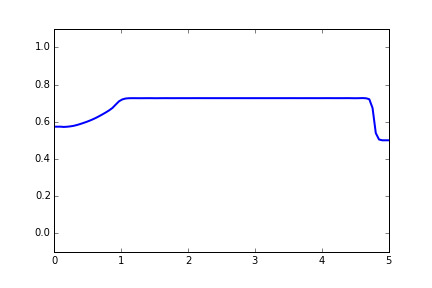
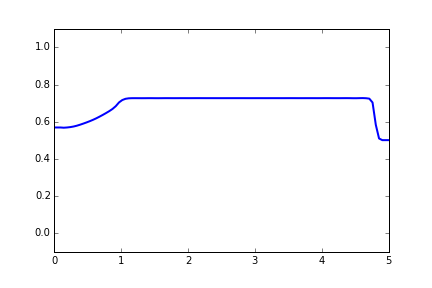
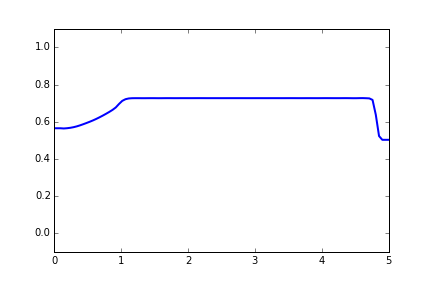
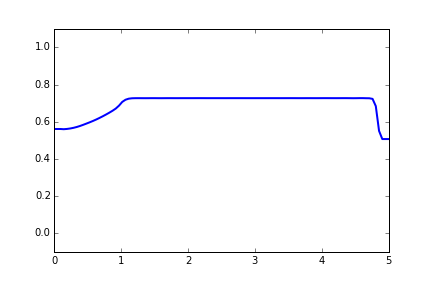
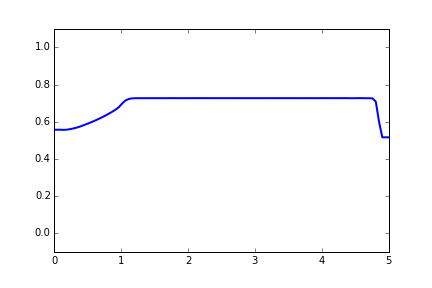
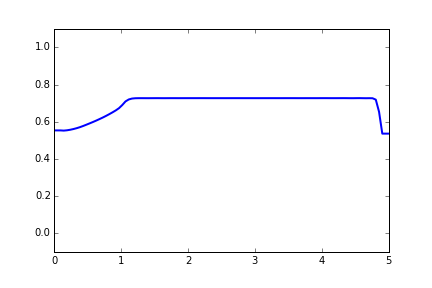
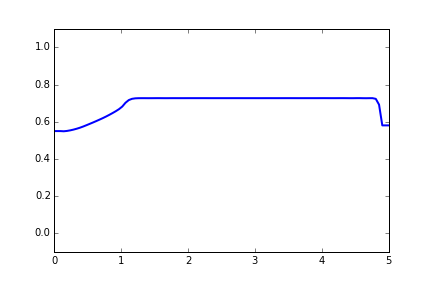
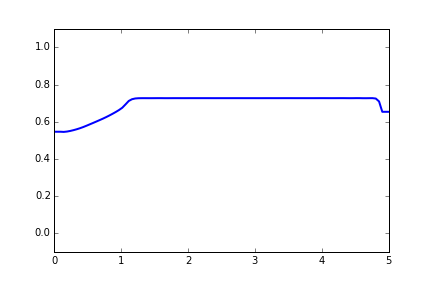
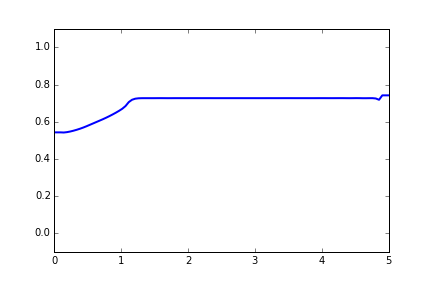
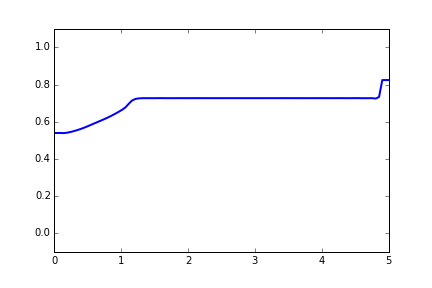
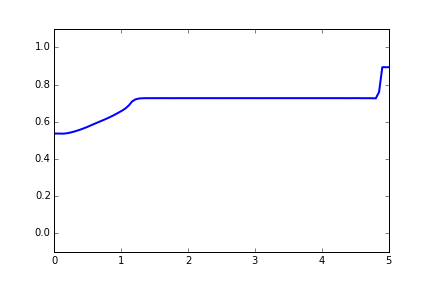
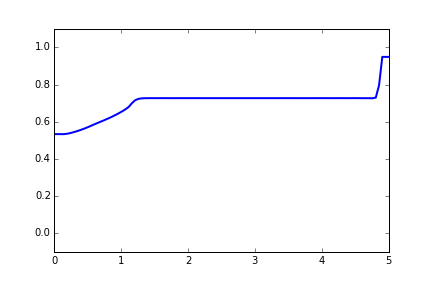
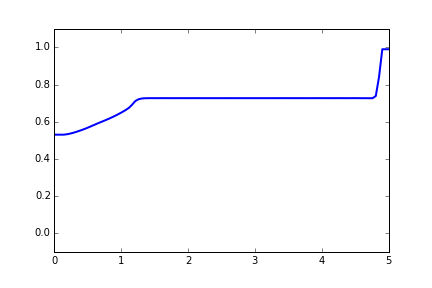
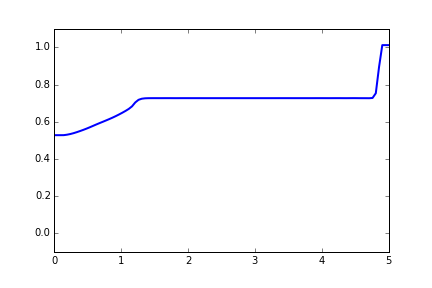
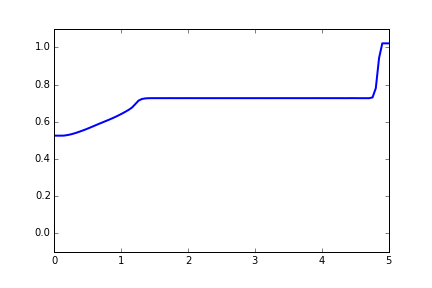
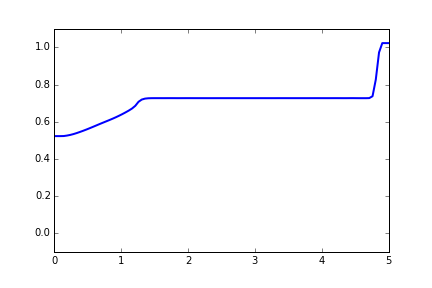
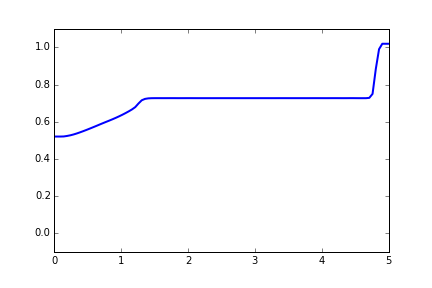
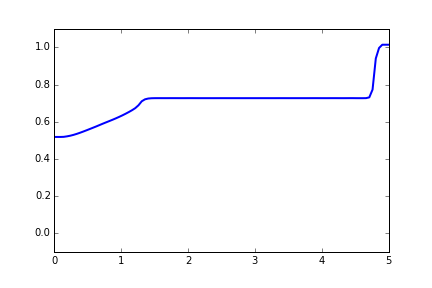
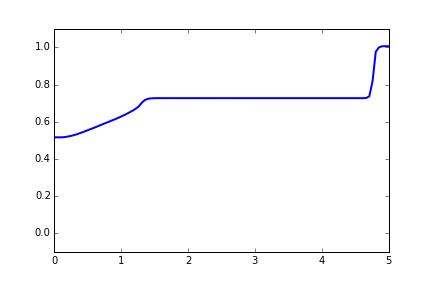
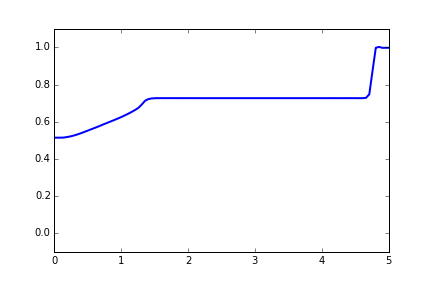
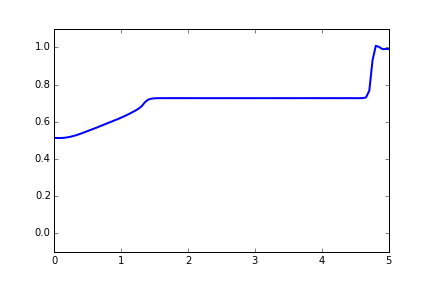
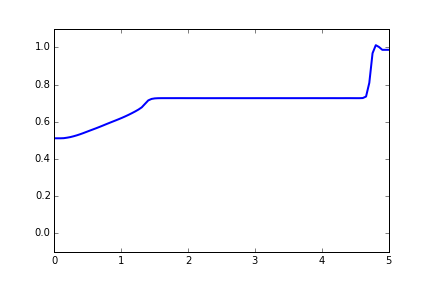
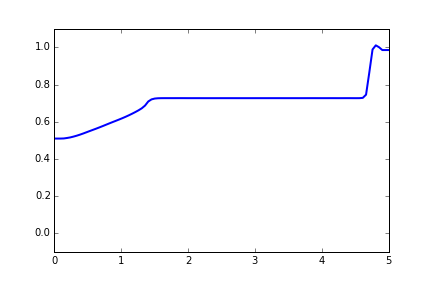
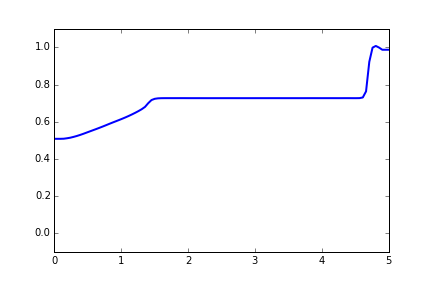
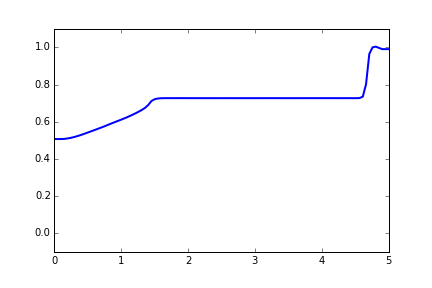
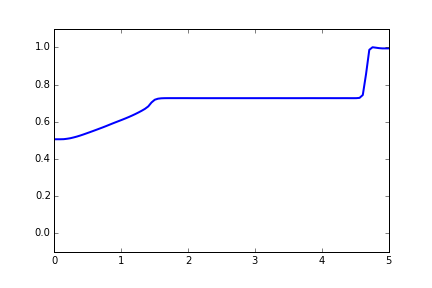
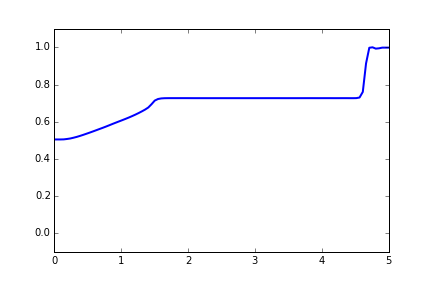
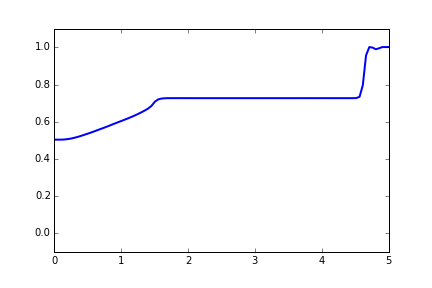
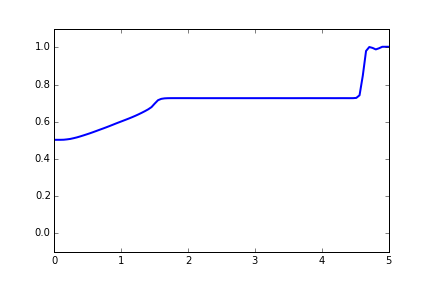
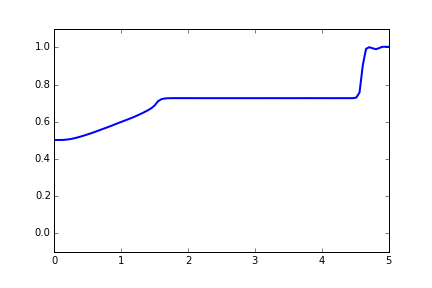
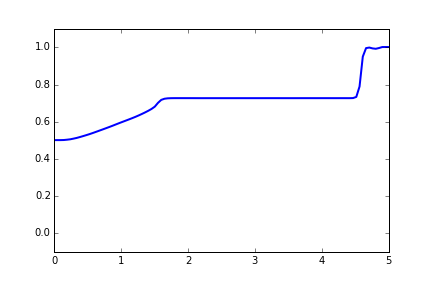
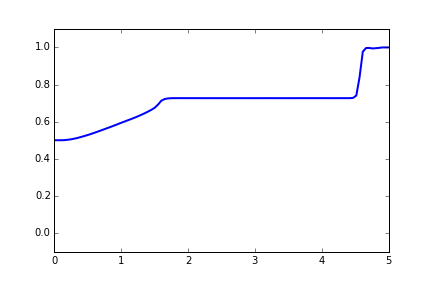
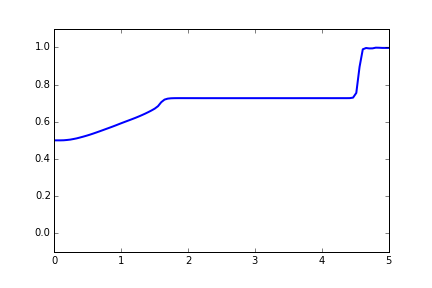
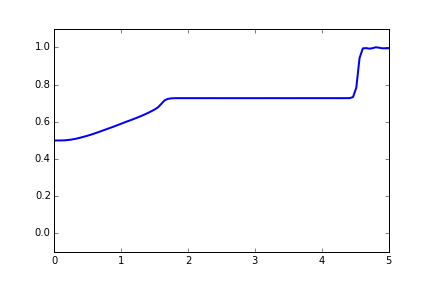
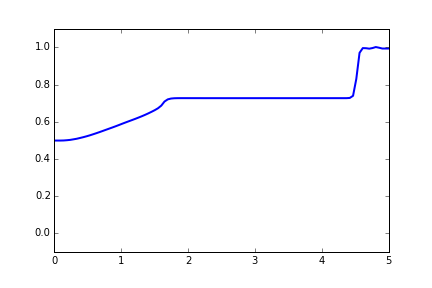
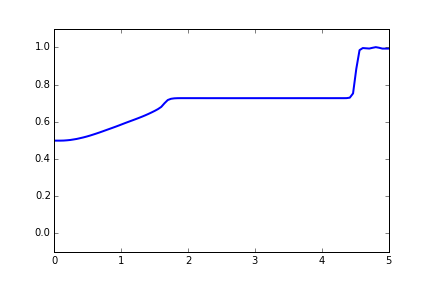
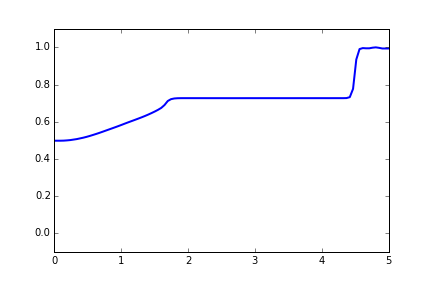
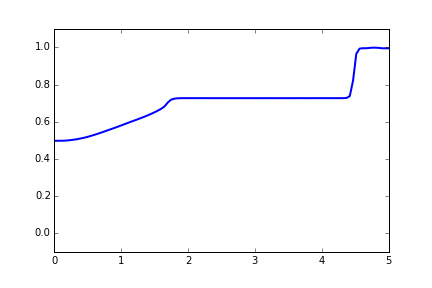
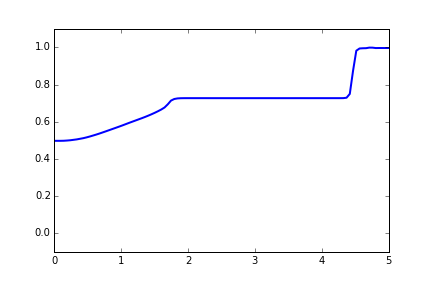
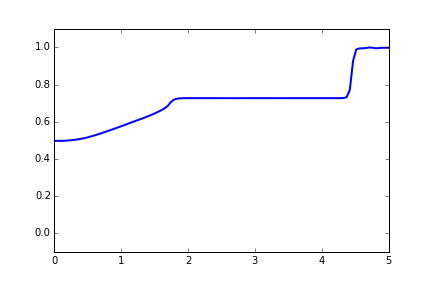
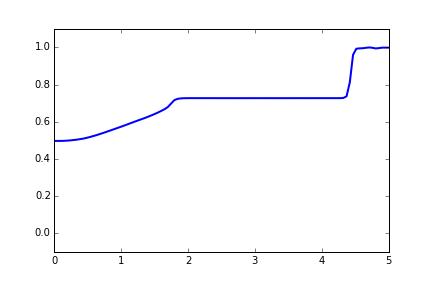
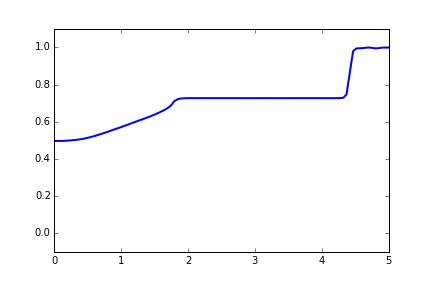
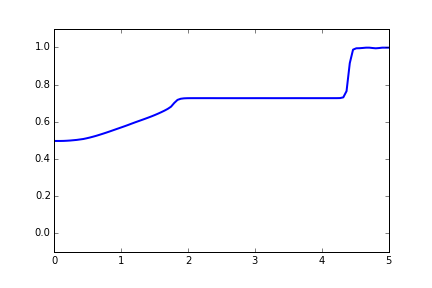
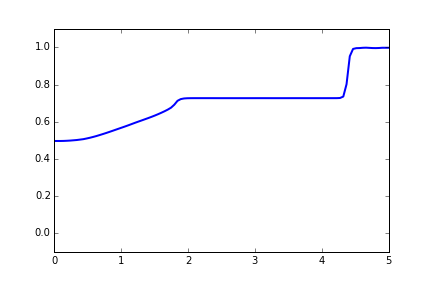
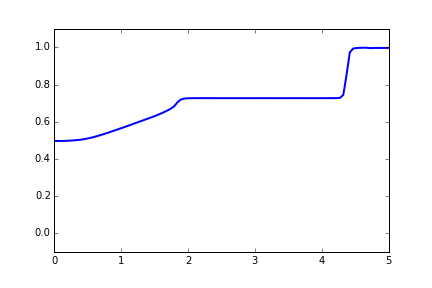

In [86]:
from matplotlib import animation
from JSAnimation import IPython_display

fig = plt.figure()
ax = plt.axes(xlim=(0, 5), ylim=(-0.1, 1.1))
line, = ax.plot([], [], lw=2)

def init():
    line.set_data([], [])
    return line,

def animate(i):
    line.set_data(x, h[i,:])
    return line,

animation.FuncAnimation(fig, animate, init_func=init,
                        frames=nt-1, interval=45)

<a id="case2"></a>
# Caso 2: rompimiento de presa, canal horizontal, fondo seco

<a id="c2-data"></a>
## Datos

In [105]:
nx = 100
x = np.linspace(0,5,nx+4)
dx = np.diff(x)[0]

nt = 100
t = np.zeros((nt+1,))
t0 = 00.
cfl = 0.45

(-1, 2)

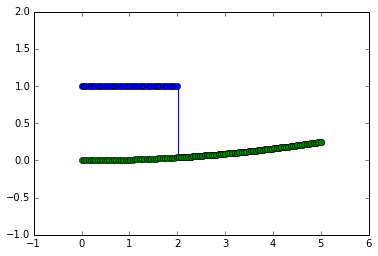

In [116]:
d = np.linspace(0,0.5,nx+4)**2
h = np.zeros((nt+1,nx+4))
hu = np.zeros((nt+1,nx+4))
h[0,:] = np.where(x<=2,1.-d,.0)
hu[0,:] = 0.

hu = np.zeros_like(h)
plt.step(x,h[0,:]+d,'o',where='mid')
plt.step(x,d,'o',where='mid')
plt.xlim(-1,6)
plt.ylim(-1,2)

<a id="c2-sim"></a>
## Simulacion

In [117]:
t,h,hu = simulate(d,h,hu,bcs_cerrado2,dx,cfl,t0,nt);

/projects/sage/sage-6.9/local/lib/python2.7/site-packages/ipykernel/__main__.py:5: RuntimeWarning: invalid value encountered in divide
/projects/sage/sage-6.9/local/lib/python2.7/site-packages/ipykernel/__main__.py:14: RuntimeWarning: invalid value encountered in divide
/projects/sage/sage-6.9/local/lib/python2.7/site-packages/ipykernel/__main__.py:15: RuntimeWarning: invalid value encountered in divide


<a id="c1-vis"></a>
## Visualización preliminar

In [121]:
t

array([ 0.        ,  0.00697446,  0.01186447,  0.01476544,  0.01638056,
        0.01720341,  0.0176174 ,  0.01811111,  0.01868751,  0.01897676,
        0.01937624,  0.01983051,  0.02032884,  0.02087307,  0.02146958,
        0.0220995 ,  0.02264639,  0.02322146,  0.02381757,  0.02443332,
        0.02507233,  0.02573718,  0.02642536,  0.02713137,  0.02782716,
        0.028543  ,  0.02927391,  0.03001818,  0.0307764 ,  0.03154966,
        0.03233504,  0.03313163,  0.03393215,  0.03474288,  0.03556401,
        0.03639619,  0.0372426 ,  0.0381085 ,  0.03898657,  0.03986518,
        0.04074818,  0.0416361 ,  0.04253117,  0.04343649,  0.0443575 ,
        0.04528408,  0.0462159 ,  0.0471523 ,  0.04809491,  0.04904486,
        0.05000516,  0.05097555,  0.05195102,  0.05293182,  0.05391825,
        0.05491021,  0.05590897,  0.05691588,  0.05792609,  0.0589419 ,
        0.05996074,  0.06098444,  0.06201365,  0.06304943,  0.06408776,
        0.06513076,  0.06617733,  0.06722848,  0.06828499,  0.06

In [120]:
hu[20,:]

array([  1.94706909e-04,   1.94706909e-04,  -1.94706909e-04,
        -3.86894667e-03,  -2.42780550e-02,  -3.09349053e-02,
        -3.41041896e-02,  -3.76280778e-02,  -5.15268363e-02,
        -5.74715786e-02,  -6.28037169e-02,  -7.03036104e-02,
        -7.69979662e-02,  -8.35873721e-02,  -9.02341822e-02,
        -9.68666111e-02,  -1.03485373e-01,  -1.10089063e-01,
        -1.16676727e-01,  -1.23247411e-01,  -1.29800162e-01,
        -1.36334028e-01,  -1.42848057e-01,  -1.49341295e-01,
        -1.55812790e-01,  -1.62261589e-01,  -1.68686739e-01,
        -1.75087288e-01,  -1.81462285e-01,  -1.87810766e-01,
        -1.94132046e-01,  -2.00425134e-01,  -2.06709782e-01,
        -2.12941812e-01,  -2.19168174e-01,  -2.25470104e-01,
        -2.30699884e-01,  -2.37041710e-01,  -2.37568127e-01,
        -1.96098235e-01,   3.81568764e-02,   6.04787960e-01,
         4.43771758e-01,   1.67948848e-01,   6.11739952e-02,
         3.74982952e-02,   4.32549607e-02,   8.34773098e-02,
         2.61602542e-03,

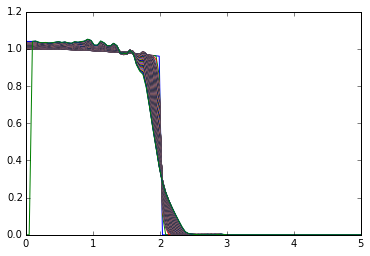

In [122]:
plt.plot(x,h[::1,:].T);

## Animacion Javascript


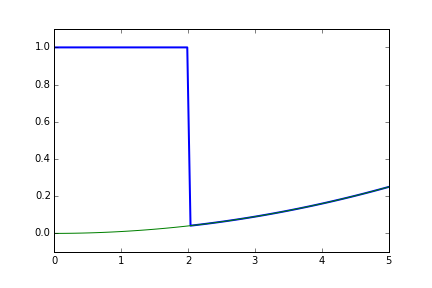
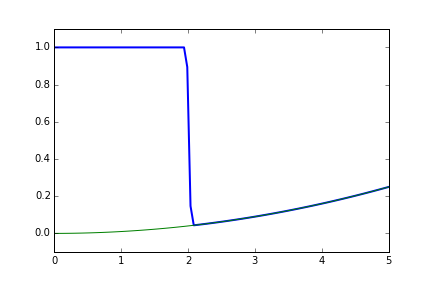
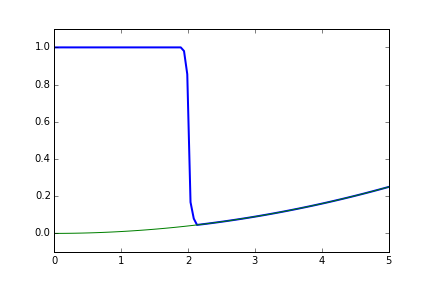
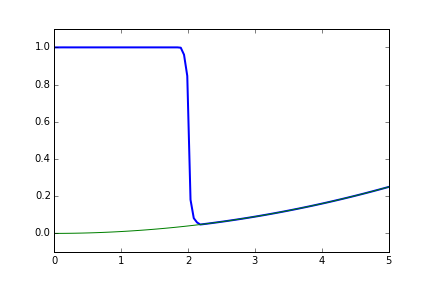
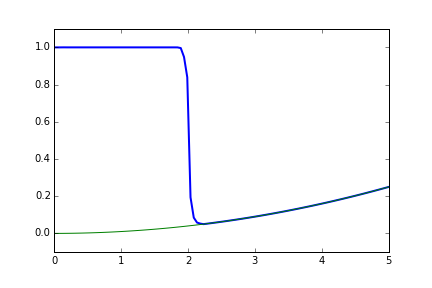
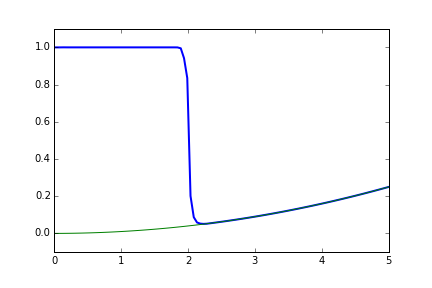
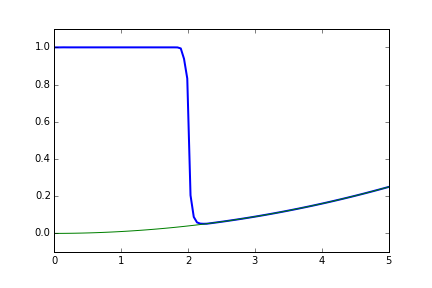
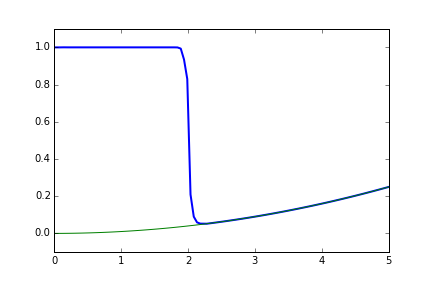
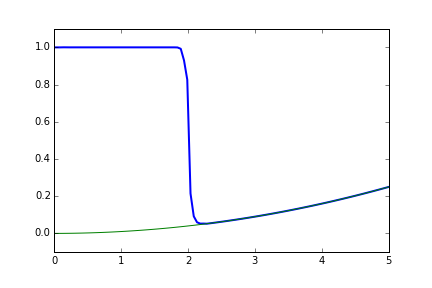
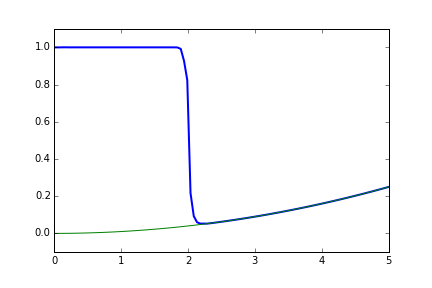
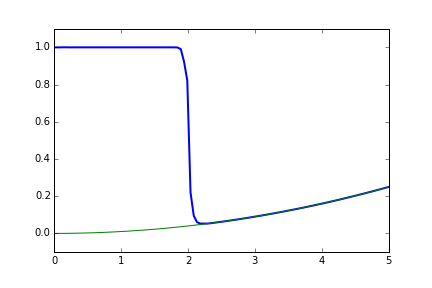
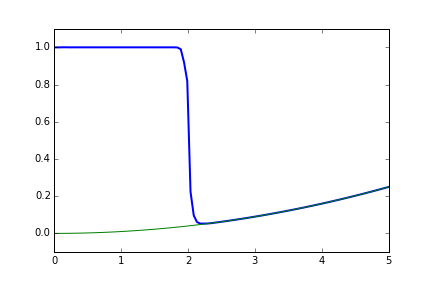
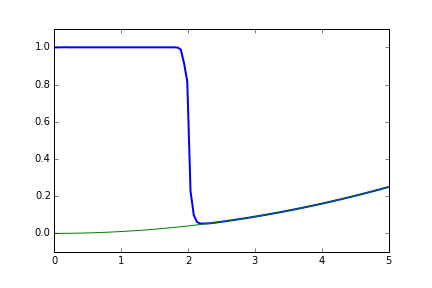
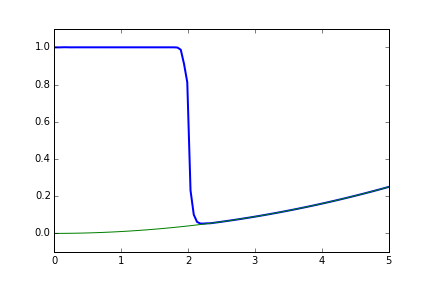
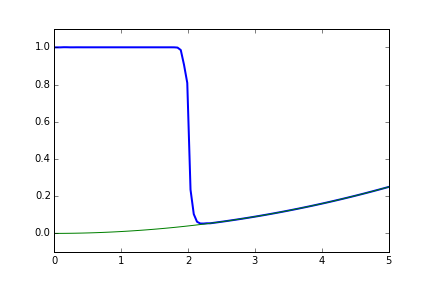
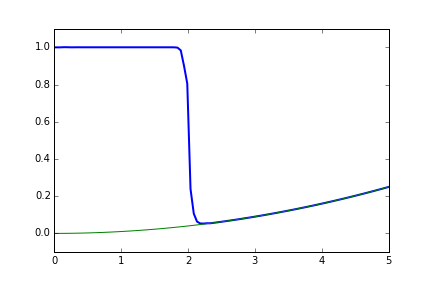
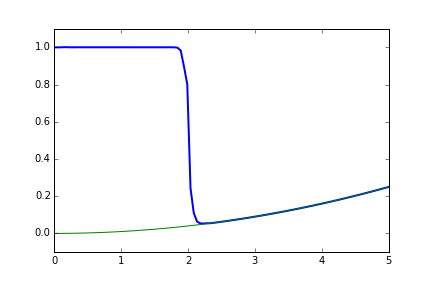
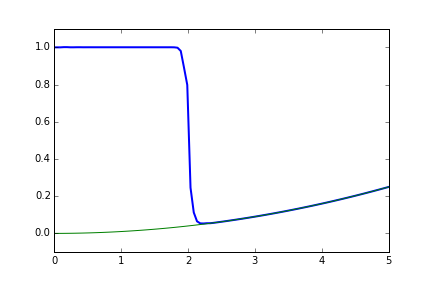
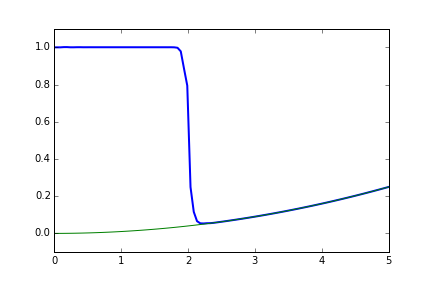
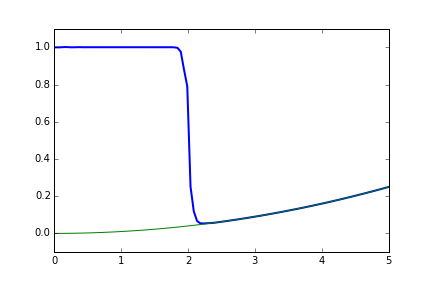
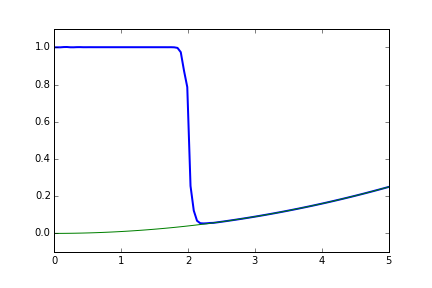
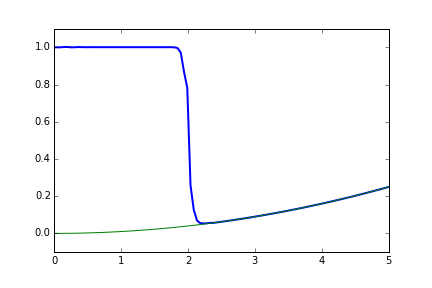
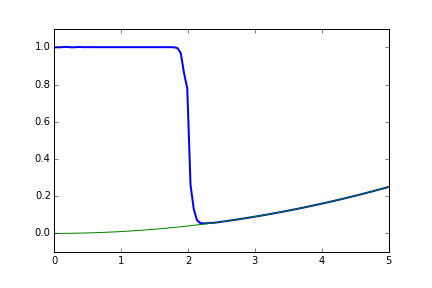
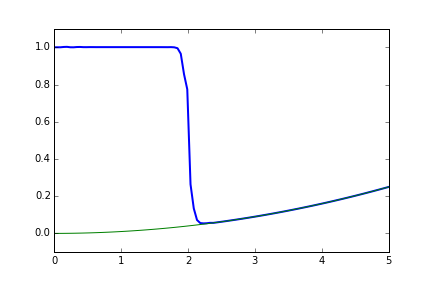
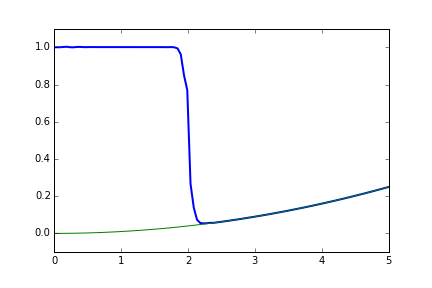
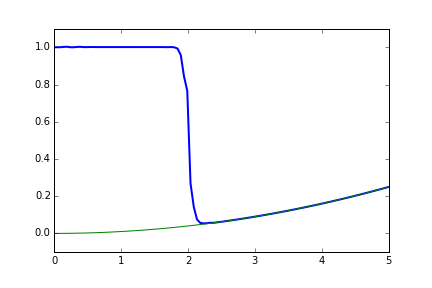
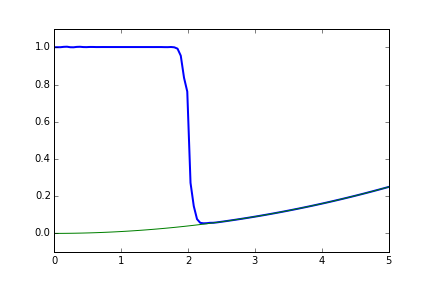
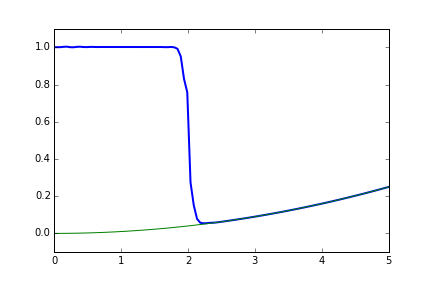
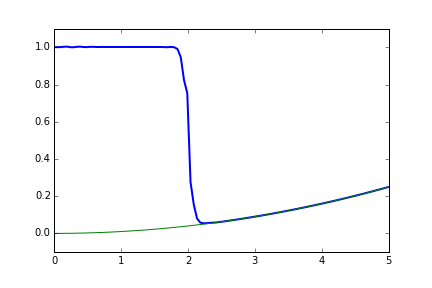
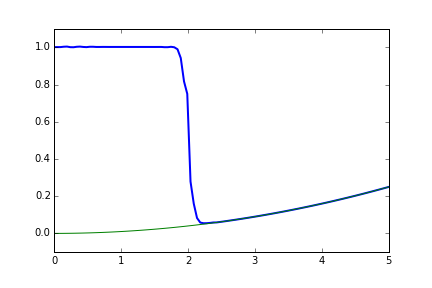
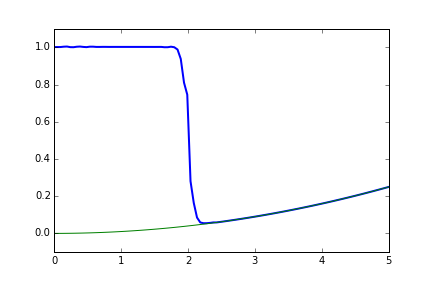
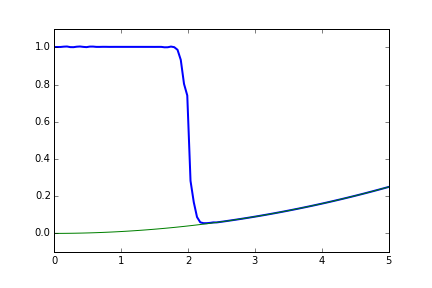
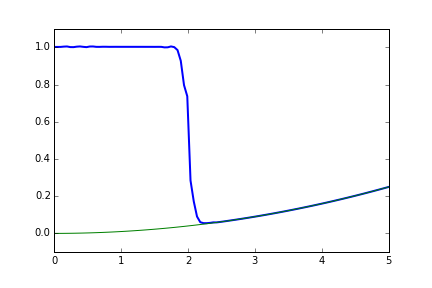
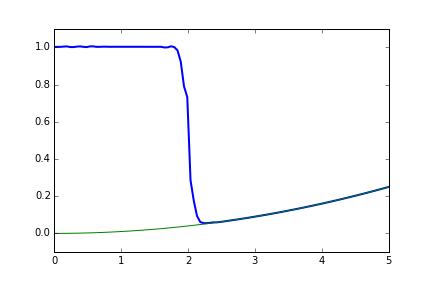
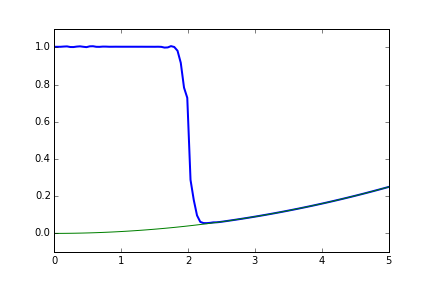
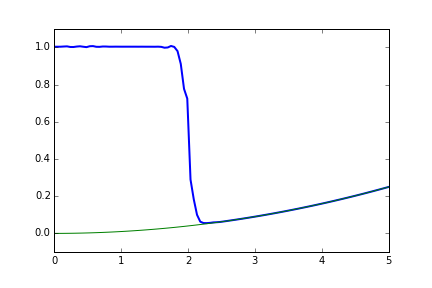
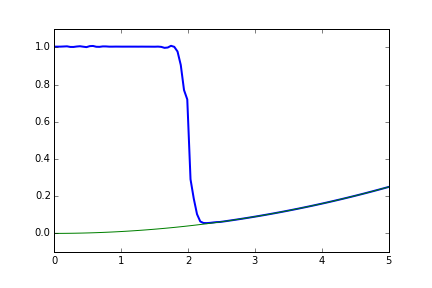
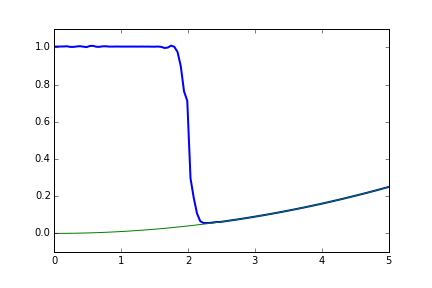
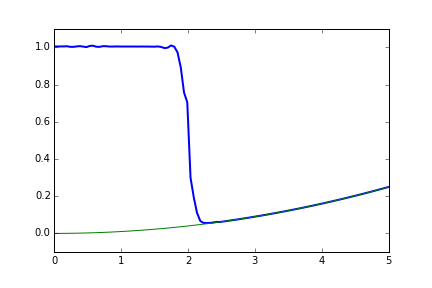
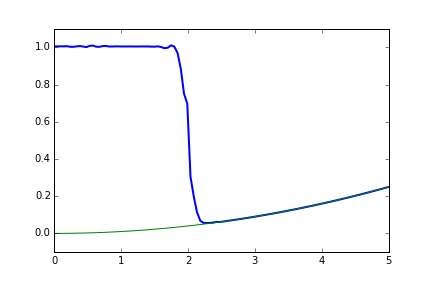
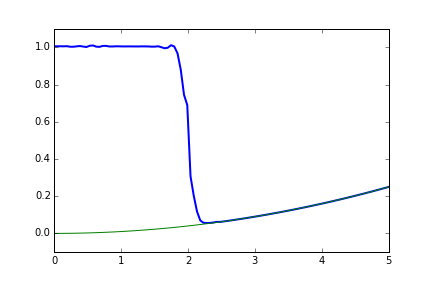
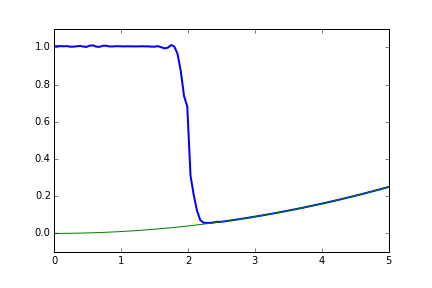
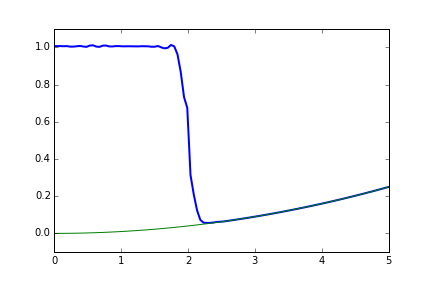
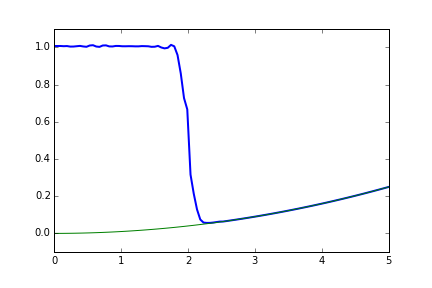
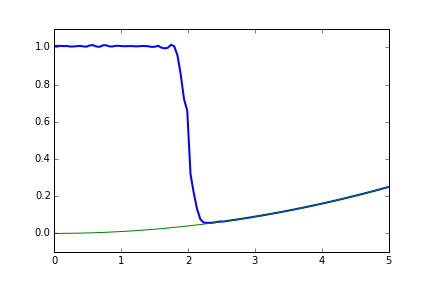
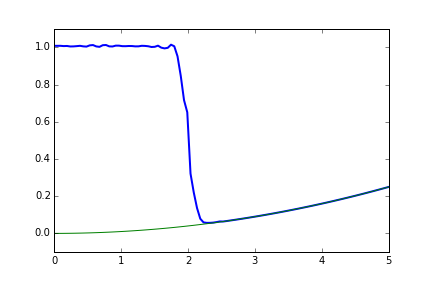
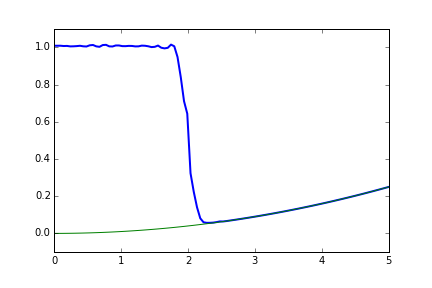
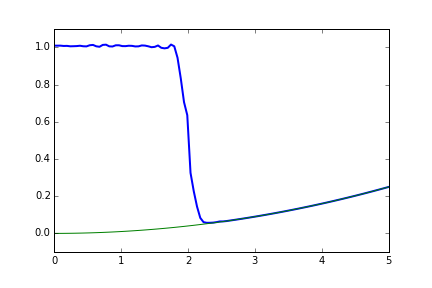
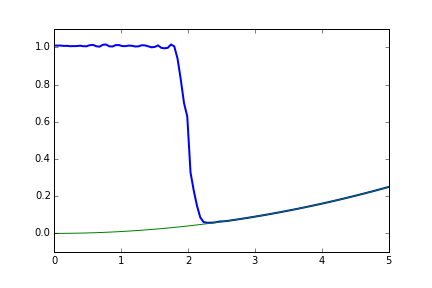
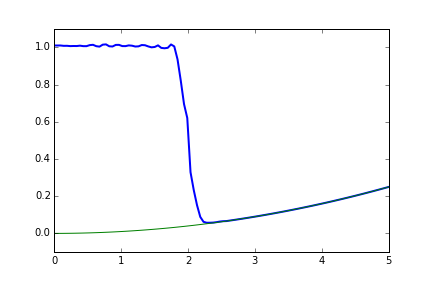
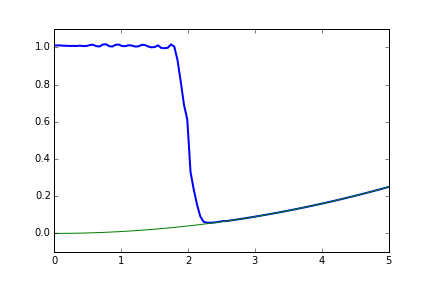
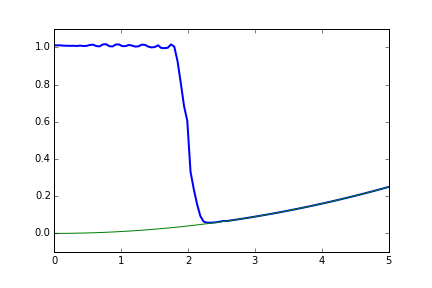
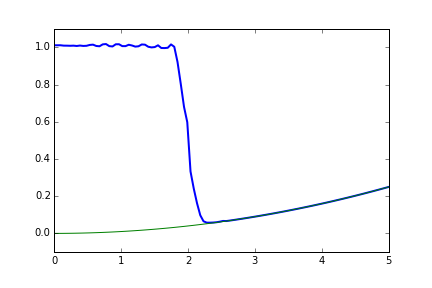
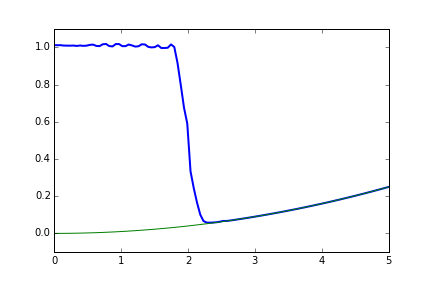
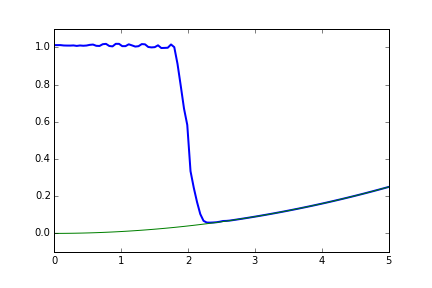
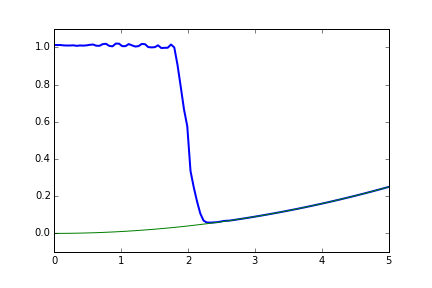
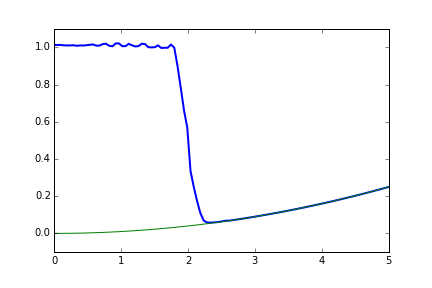
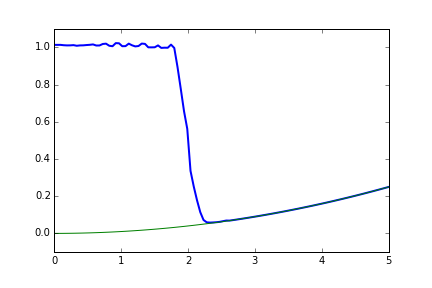
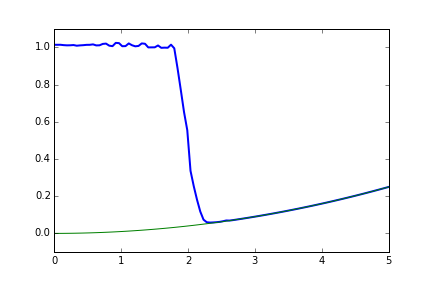
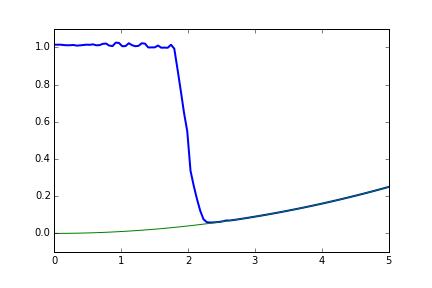
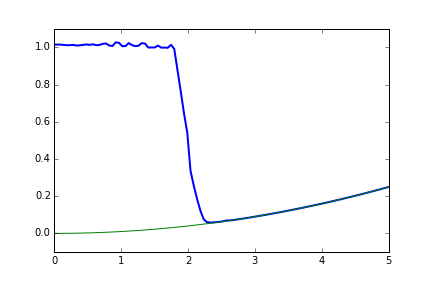
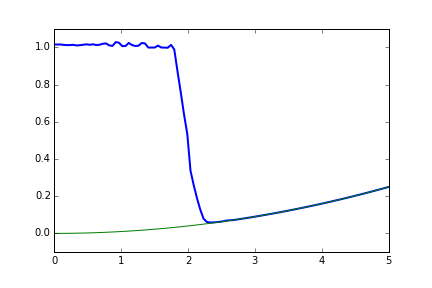
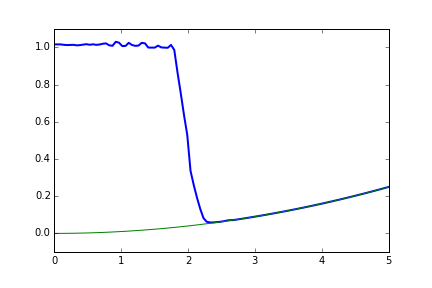
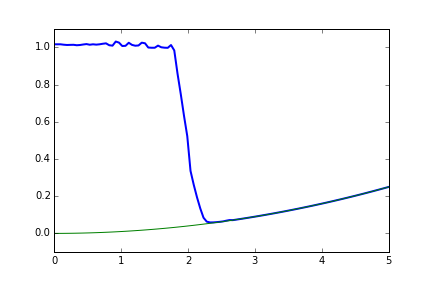
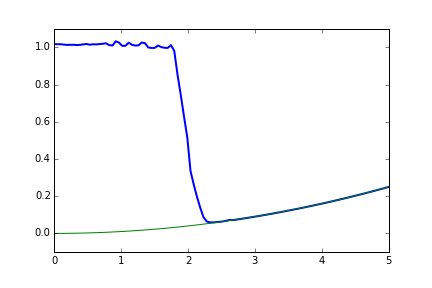
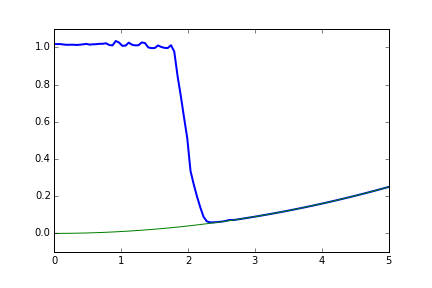
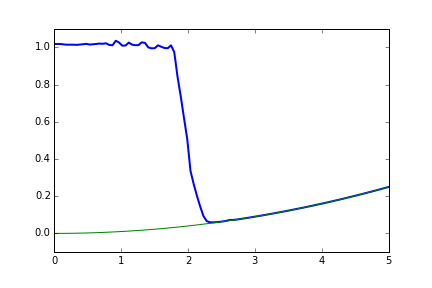
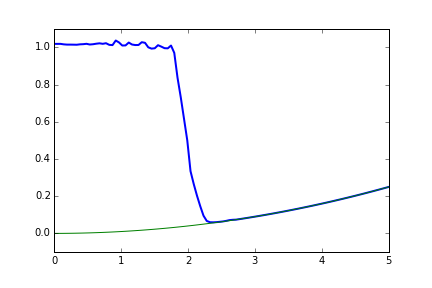
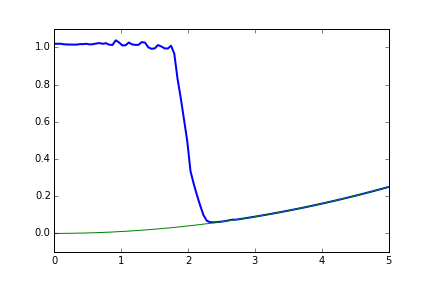
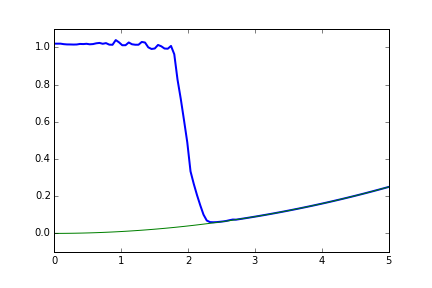
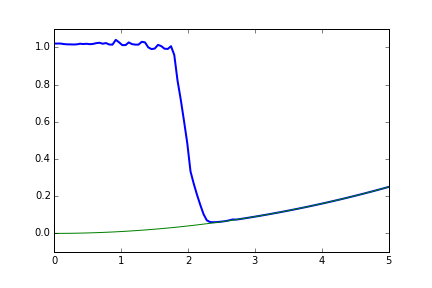
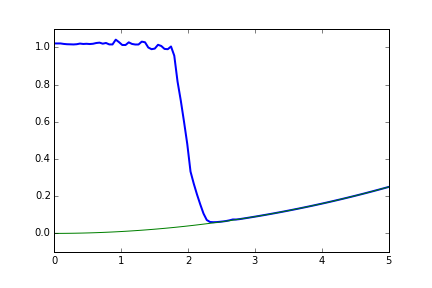
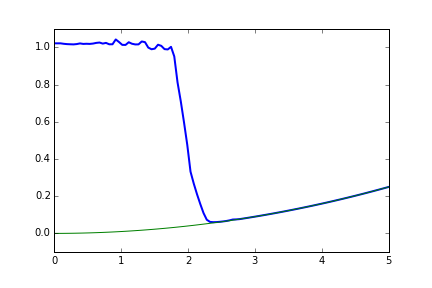
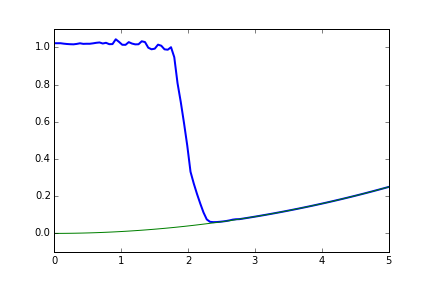
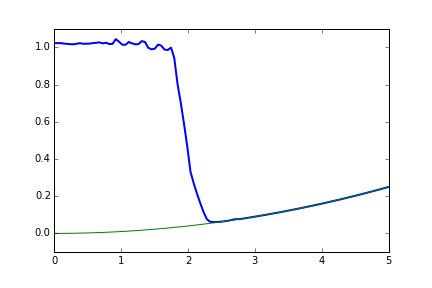
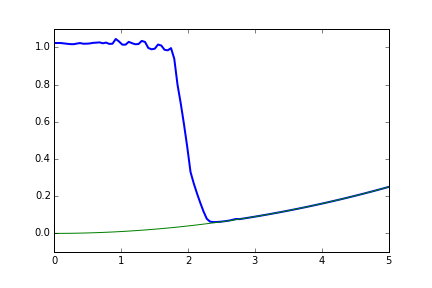
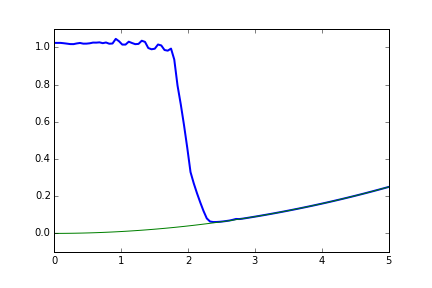
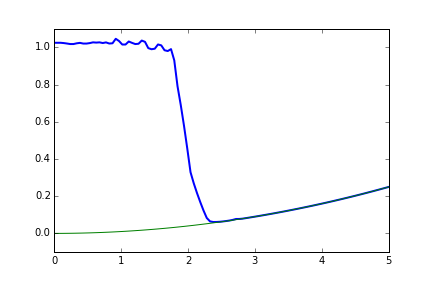
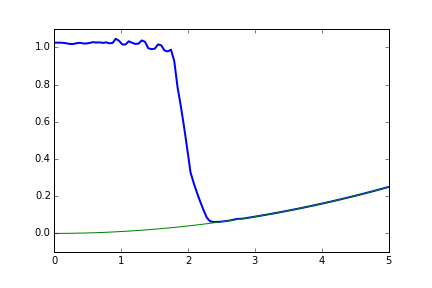
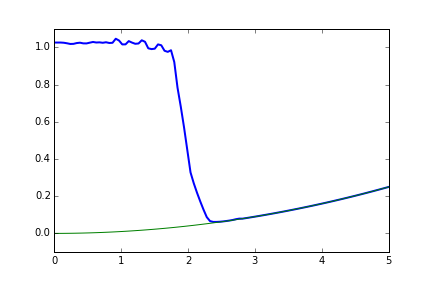
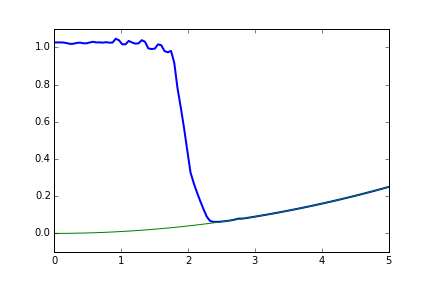
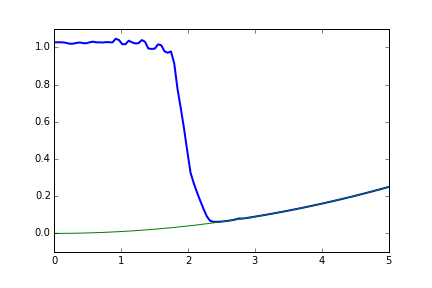
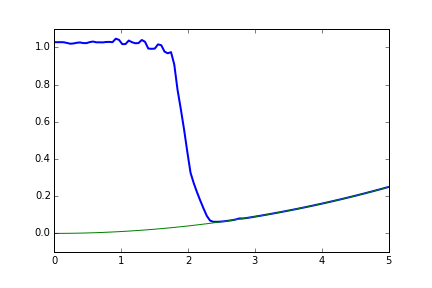
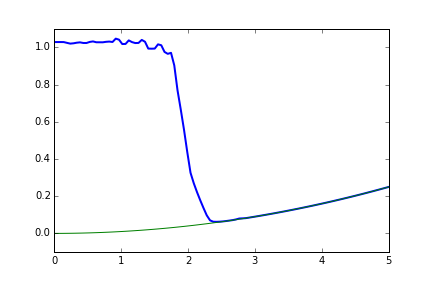
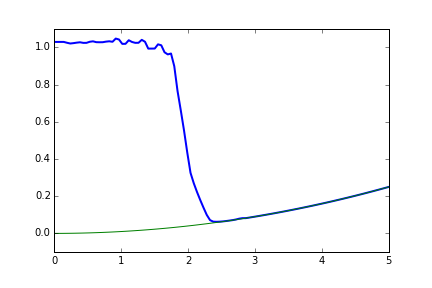
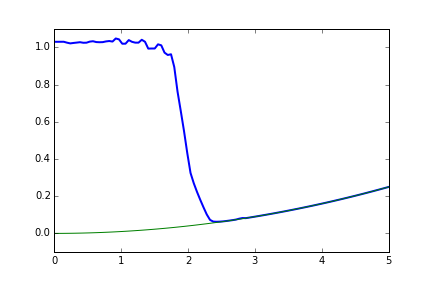
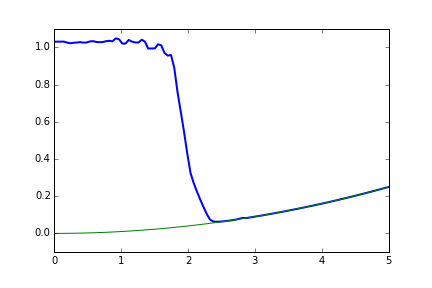
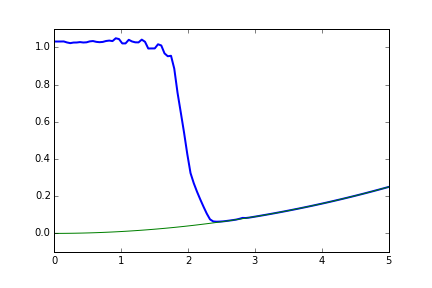
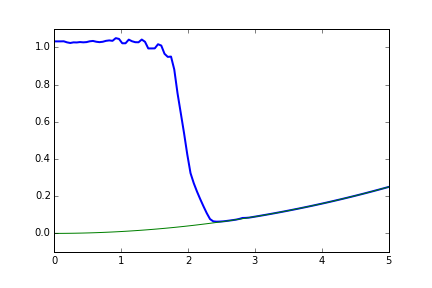
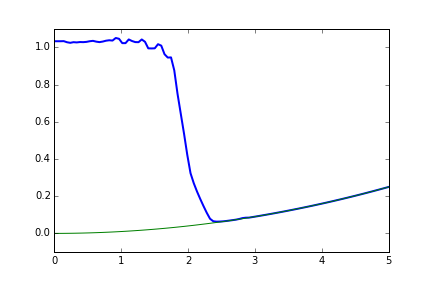
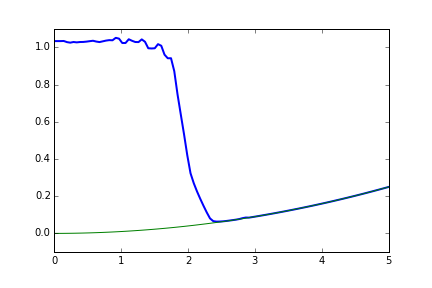
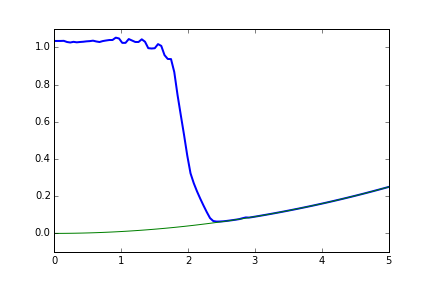
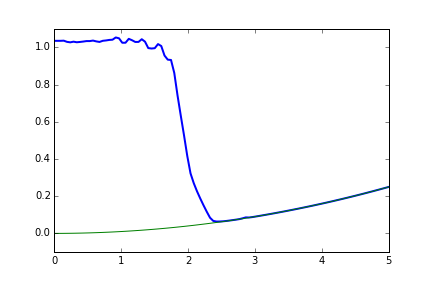
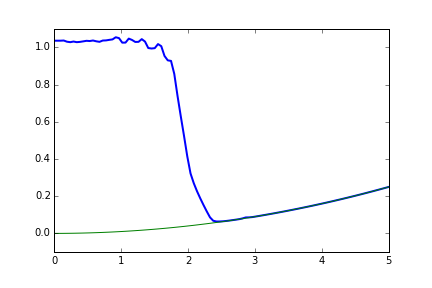
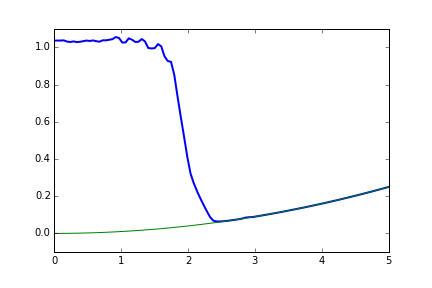
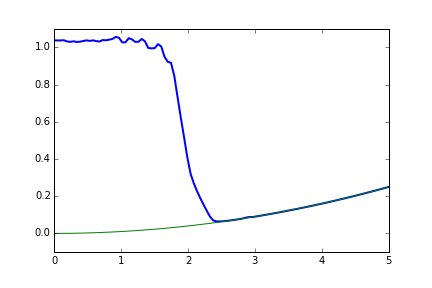
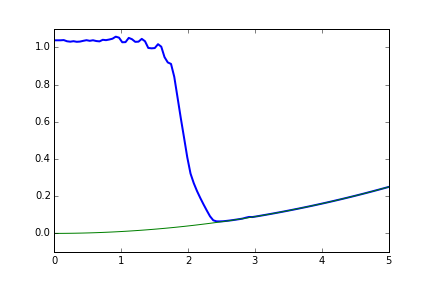
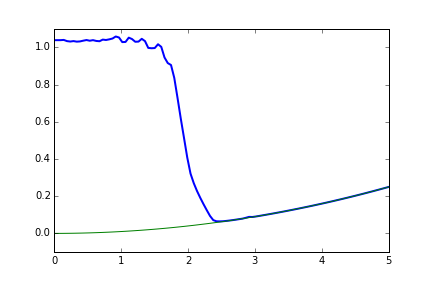
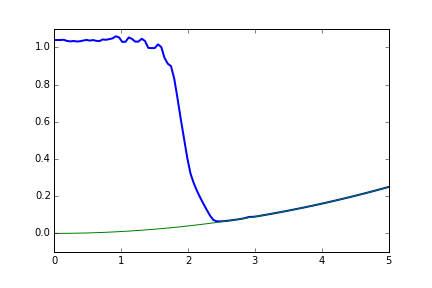

In [124]:
from matplotlib import animation
from JSAnimation import IPython_display

fig = plt.figure()
ax = plt.axes(xlim=(0, 5), ylim=(-0.1, 1.1))
line, = ax.plot([], [], lw=2)
plt.plot(x,d)
def init():
    line.set_data([], [])
    return line,

def animate(i):
    line.set_data(x, h[i,:]+d)
    return line,

animation.FuncAnimation(fig, animate, init_func=init,
                        frames=nt-1, interval=45)

# IMPLEMENTACION CON RK 2

 $m_1 = F(U_n)\Delta t$ y $m_2 = F(U_n+m_1)\Delta t$, entonces
 $$U_{n+1} = U_{n} +0.5(m_1+m_2)$$

In [133]:
def simulate_rk2(d,h,hu,bcs,dx,cfl,t0,nt):
    """
        Rutina principal que corre la simulacion
    """
    t = np.zeros((nt,))
    for n in range(nt-1):     
        dt = setdt(h,hu,n,dx,cfl)
        
        t[n+1] = t[n] + dt

        d,h,hu = bcs(d,h,hu,n)    
        fp,fm,sc = fluxes_sources(d,h,hu,n)

        m1h = -dt/dx*(fm[0,1:] - fp[0,:-1]) + sc[0,1:-1]
        m1hu = -dt/dx*(fm[1,1:] - fp[1,:-1]) + sc[1,1:-1]
        h1 = h*1.
        hu1 = hu*1.
        h1[n+1,2:-2] = h[n,2:-2] + m1h
        hu1[n+1,2:-2] = hu[n,2:-2] + m1hu
        
        fp,fm,sc = fluxes_sources(d,h1,hu1,n)
        m2h = -dt/dx*(fm[0,1:] - fp[0,:-1]) + sc[0,1:-1]
        m2hu = -dt/dx*(fm[1,1:] - fp[1,:-1]) + sc[1,1:-1]
        
        
        h[n+1,2:-2] = h[n,2:-2] +0.5*(m1h+m2h)
        hu[n+1,2:-2] = hu[n,2:-2] +0.5*(m1hu+m2hu)
        print n
    return t,h,hu

In [146]:
nx = 100
x = np.linspace(0,5,nx+4)
dx = np.diff(x)[0]

nt = 100
t = np.zeros((nt+1,))
t0 = 00.
cfl = 0.45

(-1, 2)

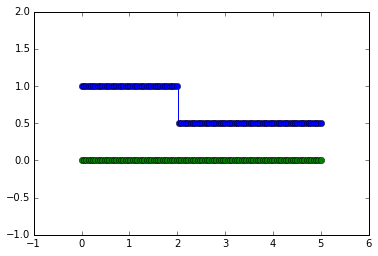

In [147]:
d = np.linspace(0,0.,nx+4)**2
h = np.zeros((nt+1,nx+4))
hu = np.zeros((nt+1,nx+4))
h[0,:] = np.where(x<=2,1.-d,.5)
hu[0,:] = 0.

hu = np.zeros_like(h)
plt.step(x,h[0,:]+d,'o',where='mid')
plt.step(x,d,'o',where='mid')
plt.xlim(-1,6)
plt.ylim(-1,2)

In [148]:
t,h,hu = simulate_rk2(d,h,hu,bcs_cerrado2,dx,cfl,t0,nt);

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98


/projects/sage/sage-6.9/local/lib/python2.7/site-packages/ipykernel/__main__.py:5: RuntimeWarning: invalid value encountered in divide


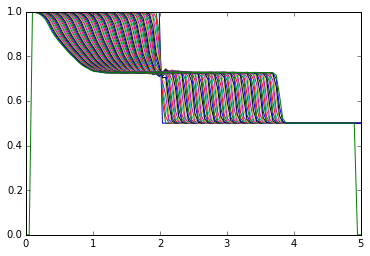

In [149]:
plt.plot(x,h[::1,:].T);


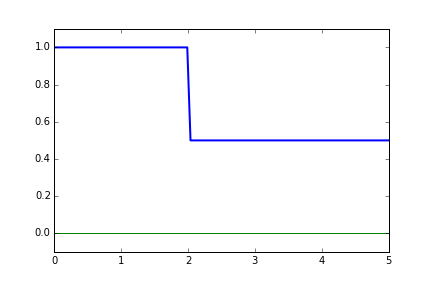
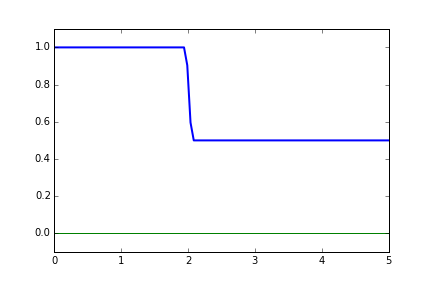
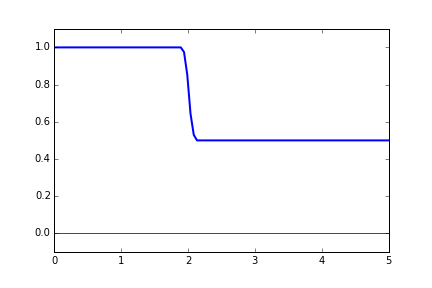
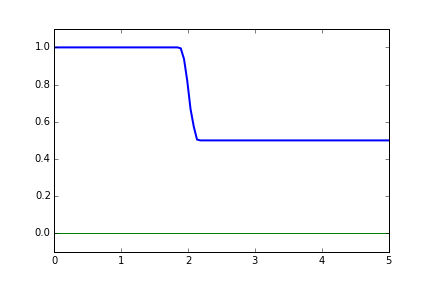
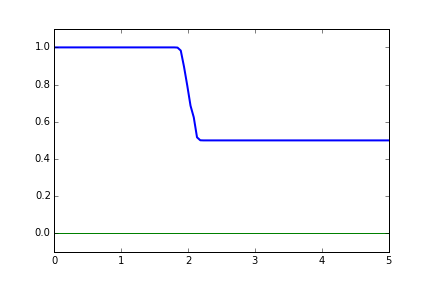
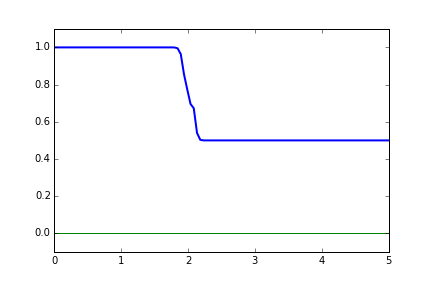
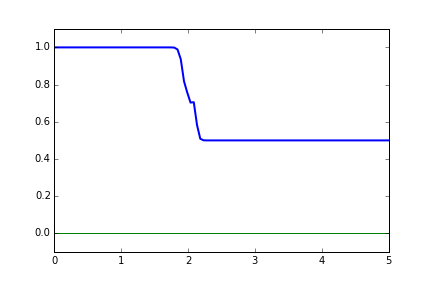
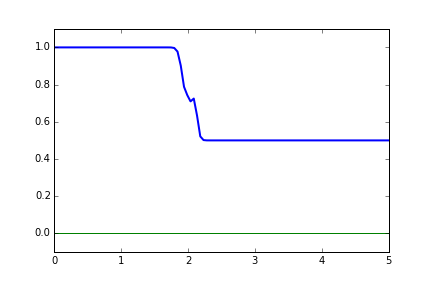
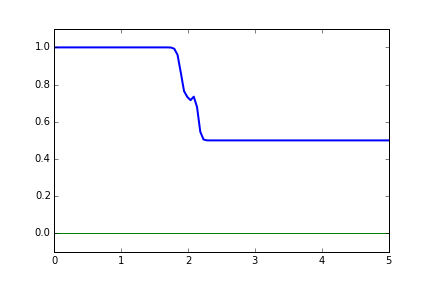
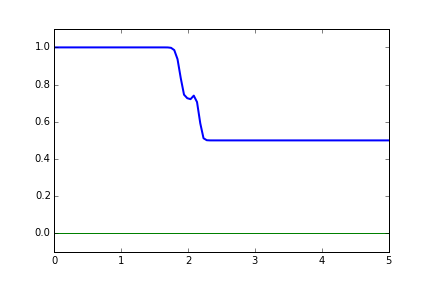
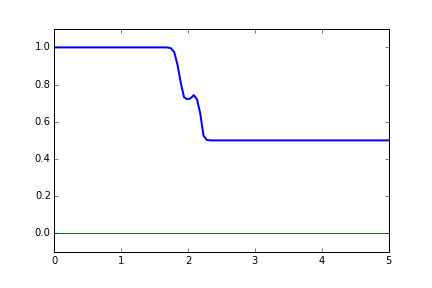
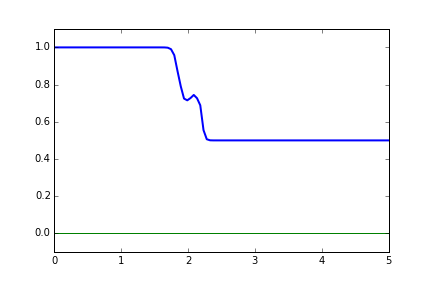
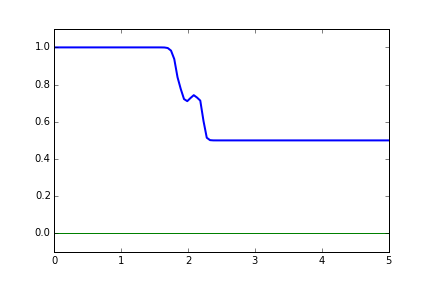
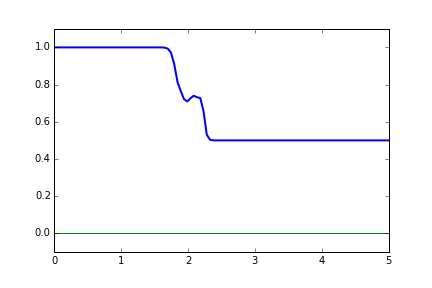
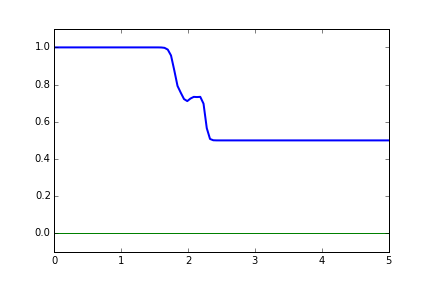
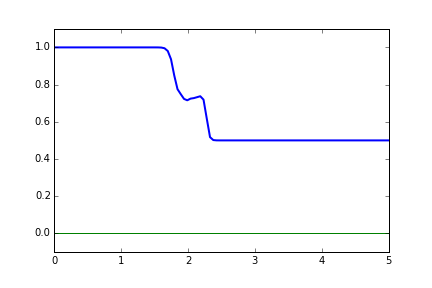
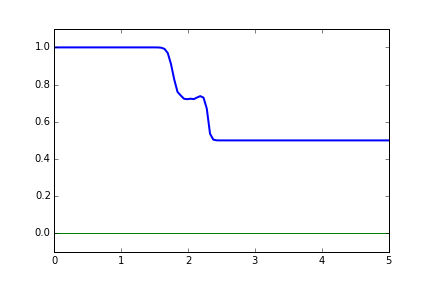
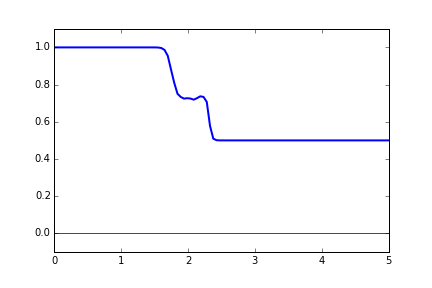
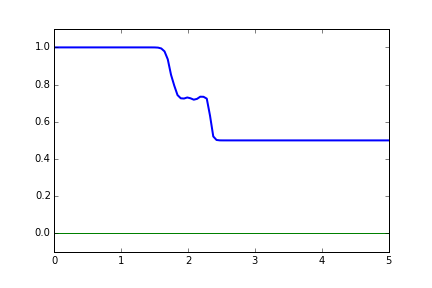
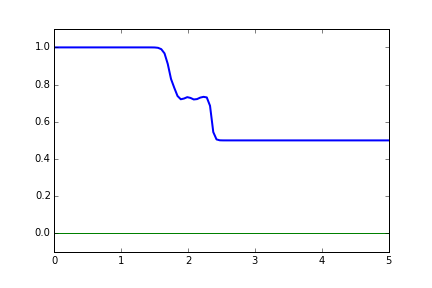
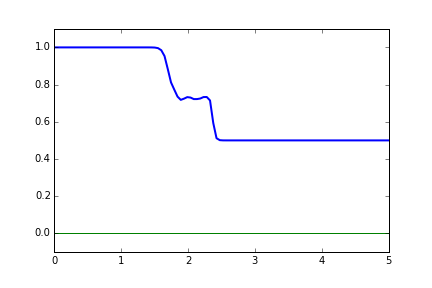
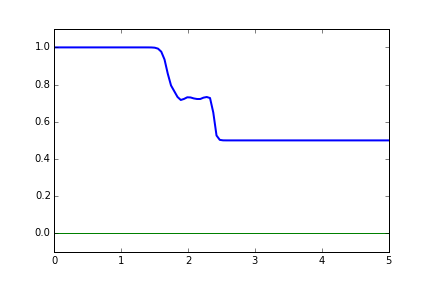
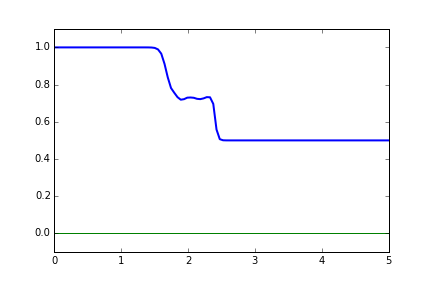
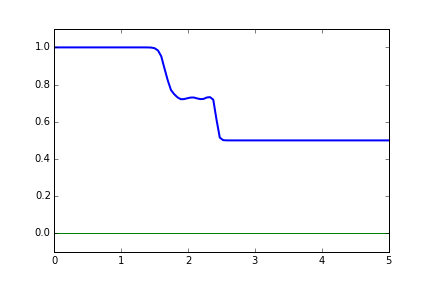
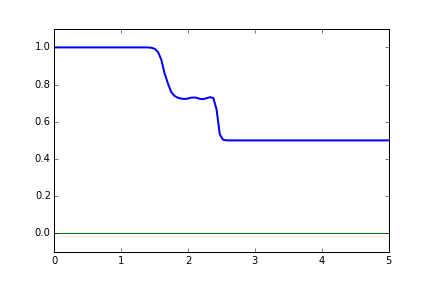
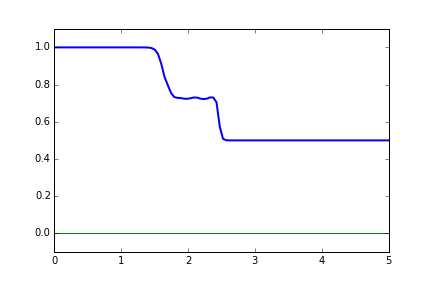
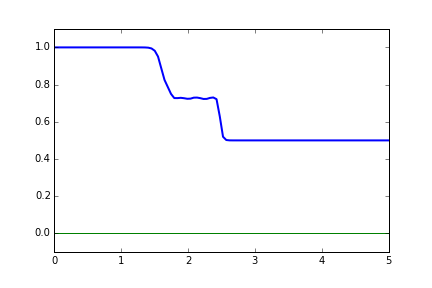
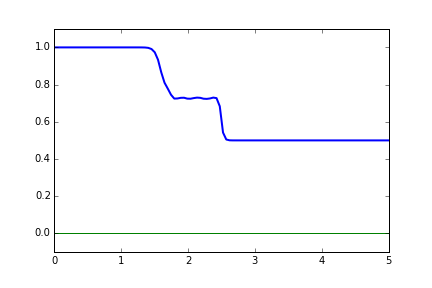
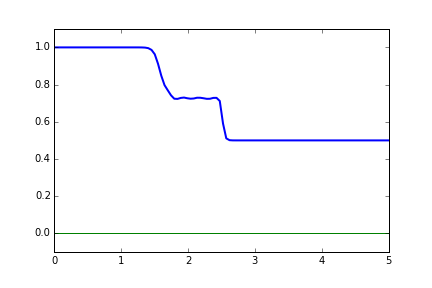
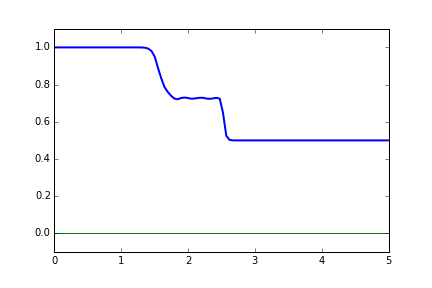
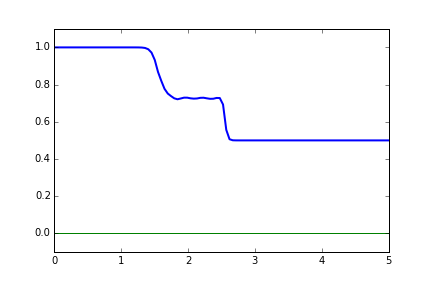
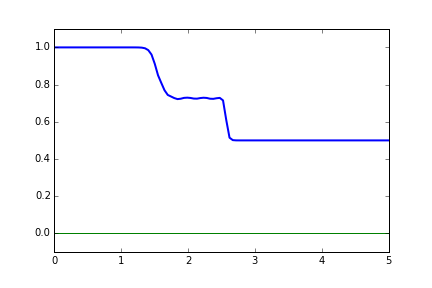
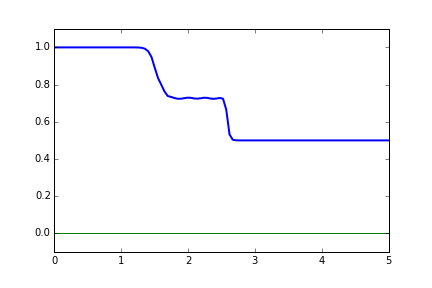
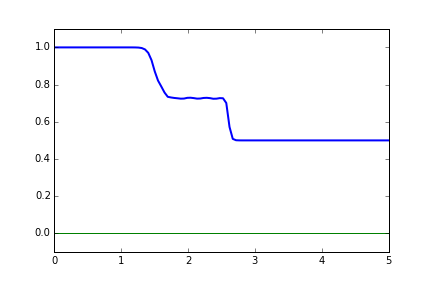
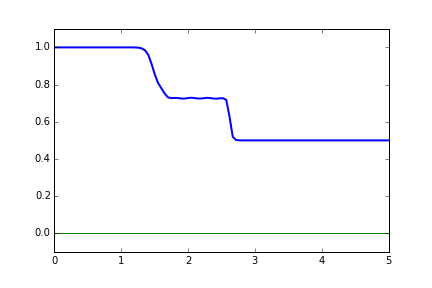
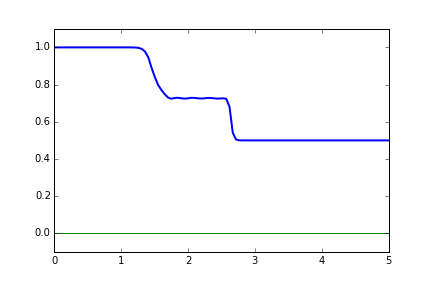
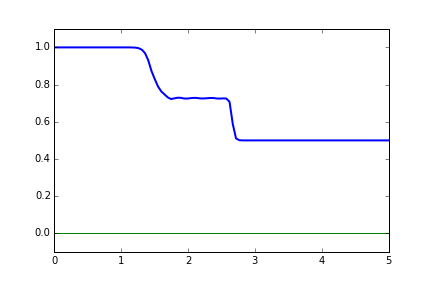
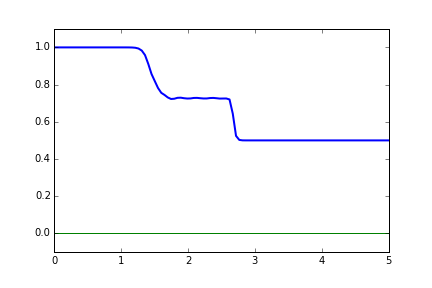
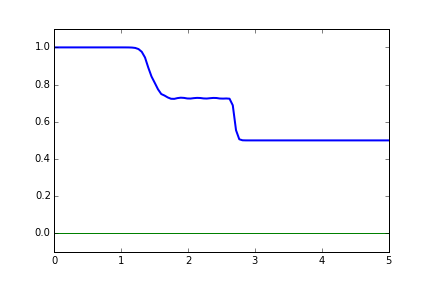
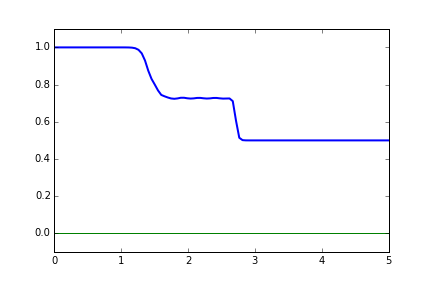
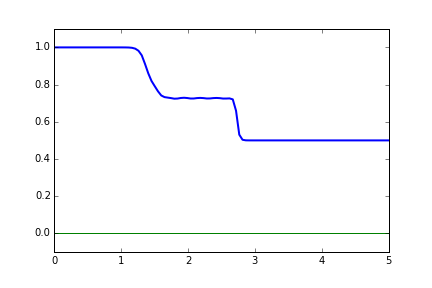
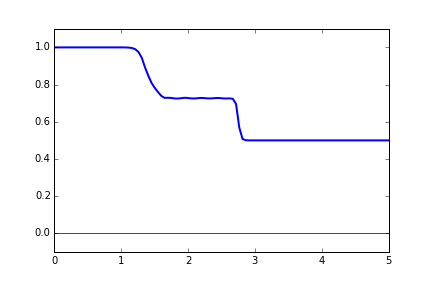
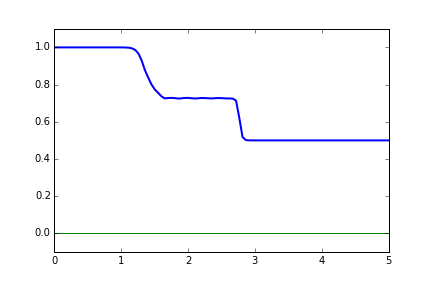
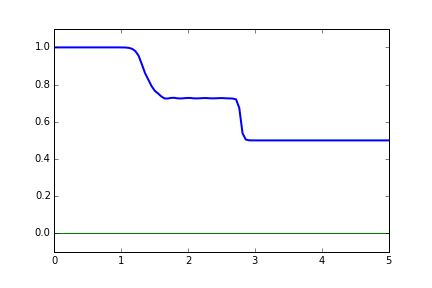
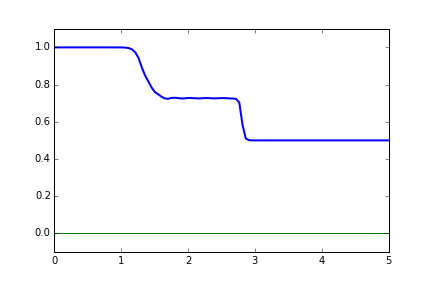
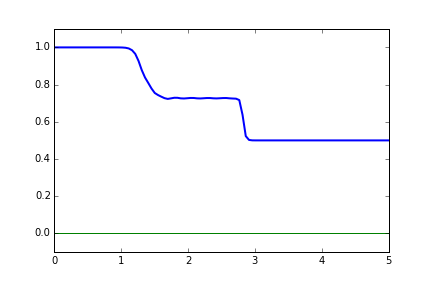
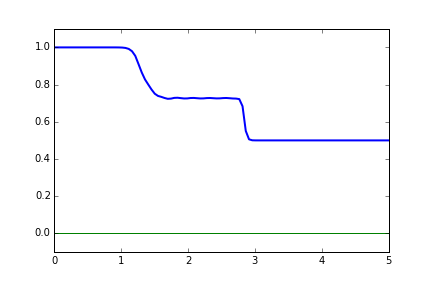
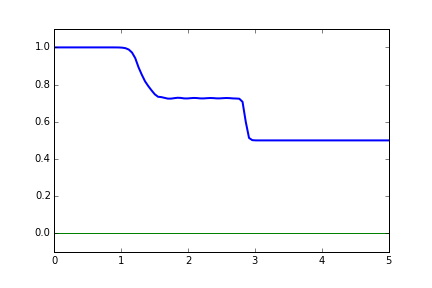
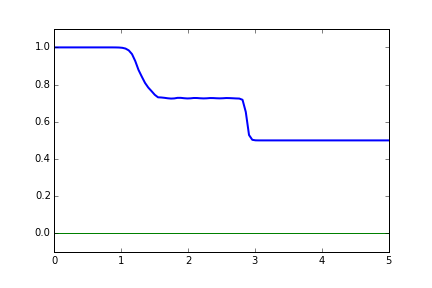
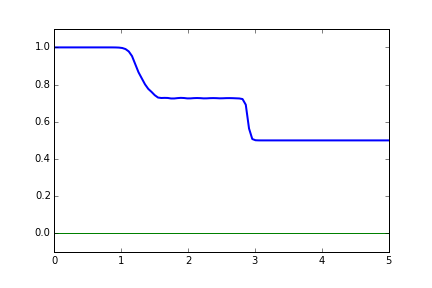
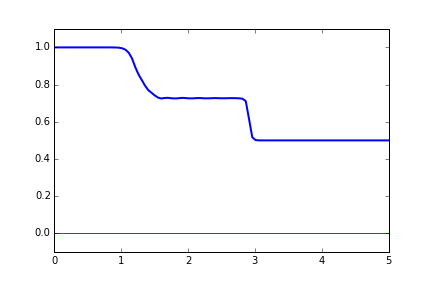
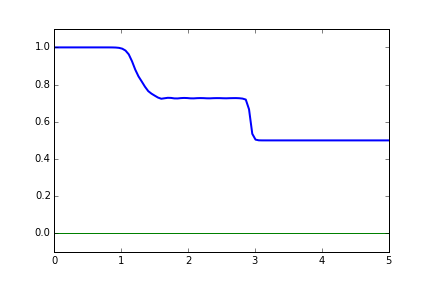
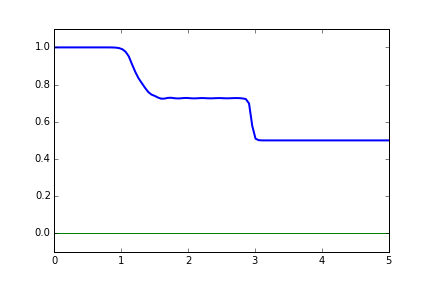
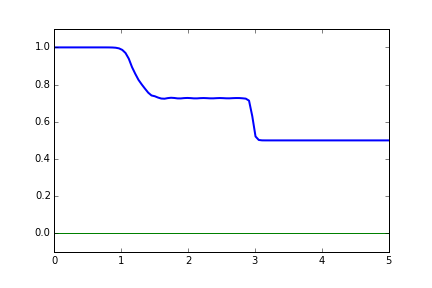
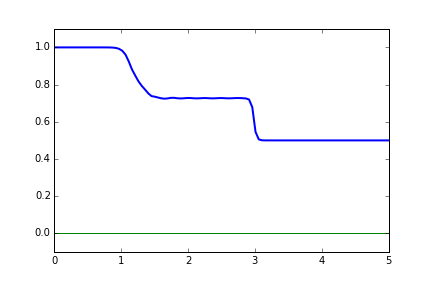
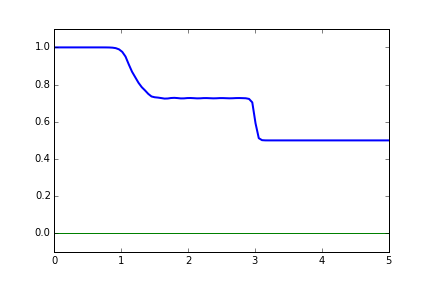
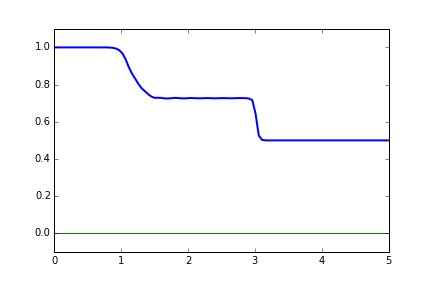
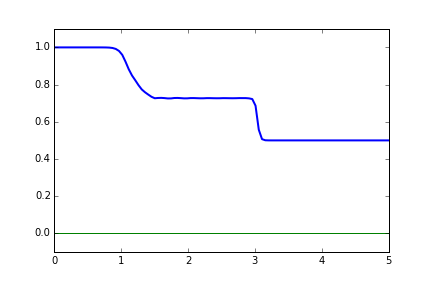
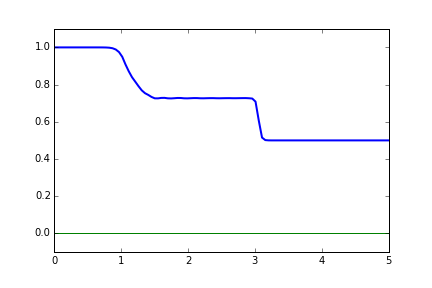
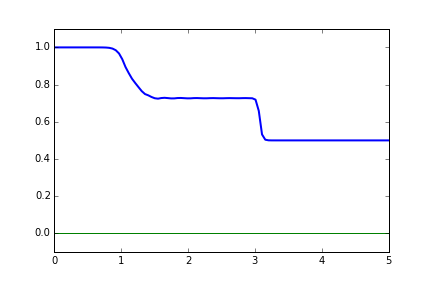
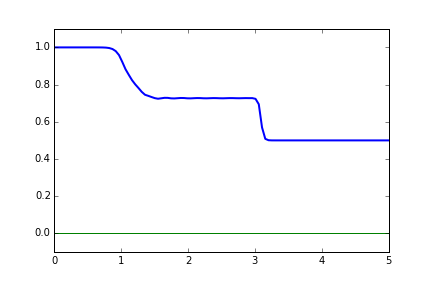
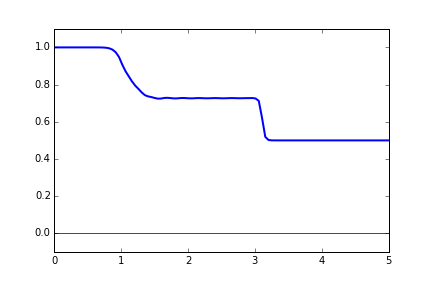
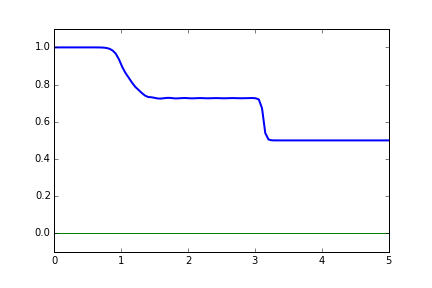
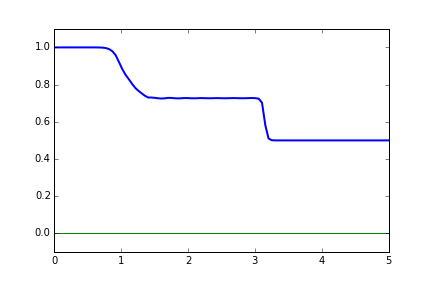
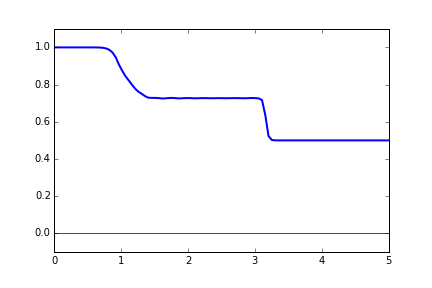
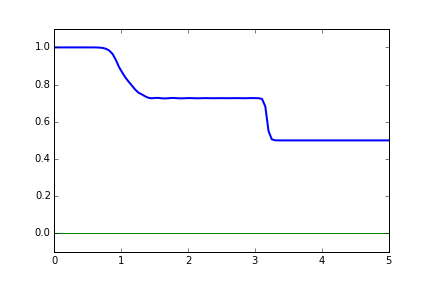
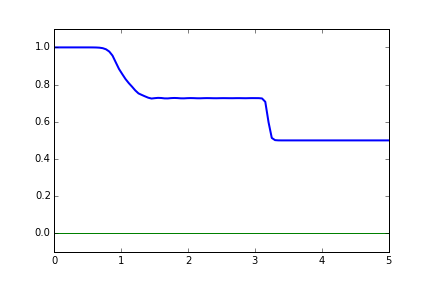
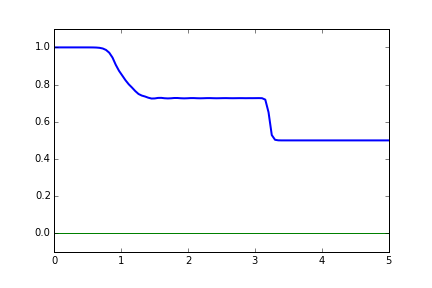
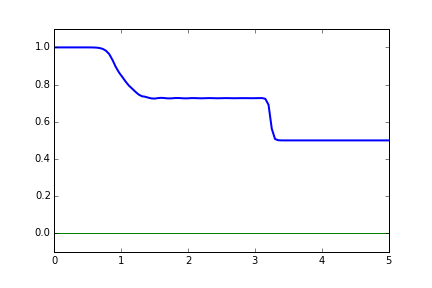
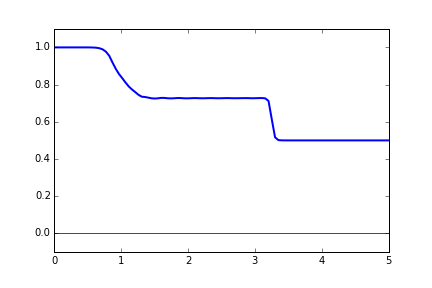
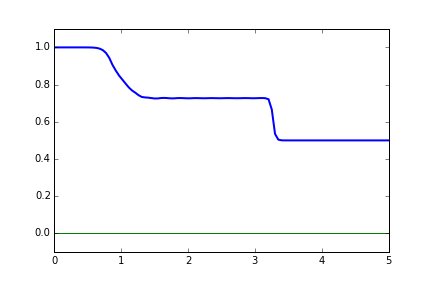
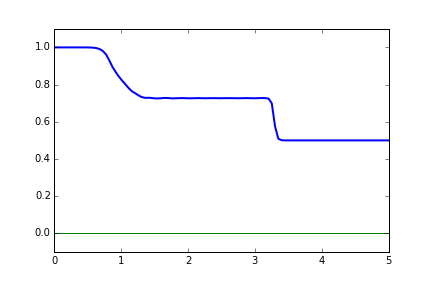
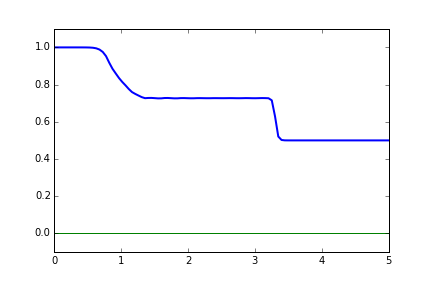
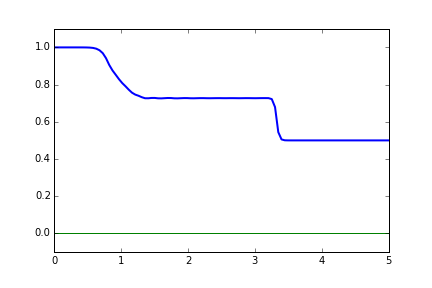
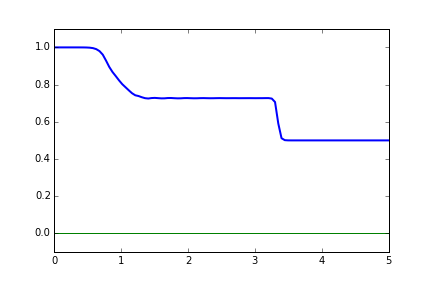
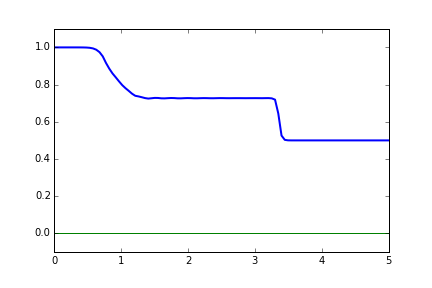
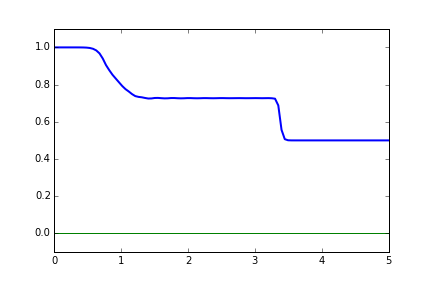
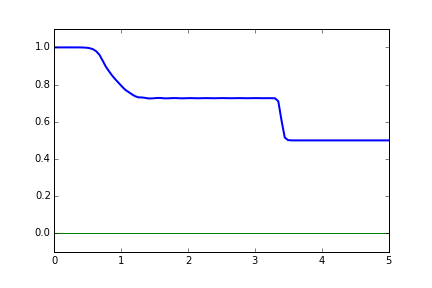
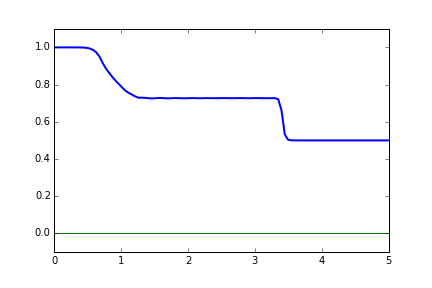
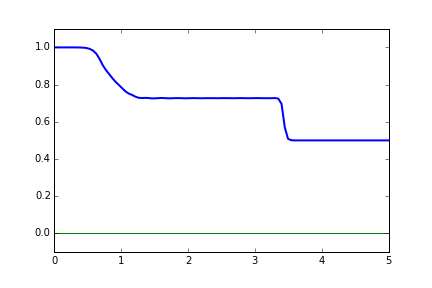
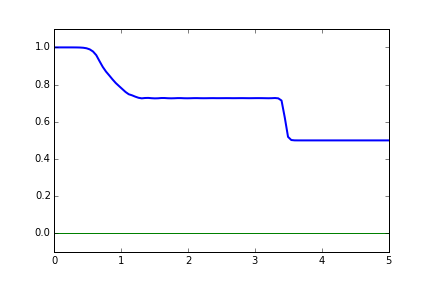
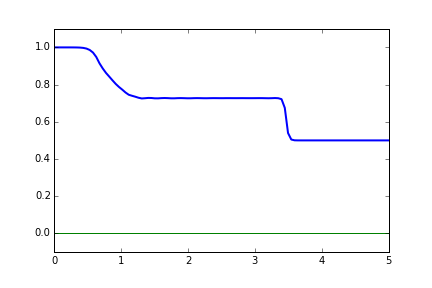
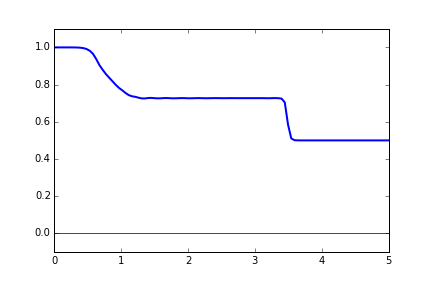
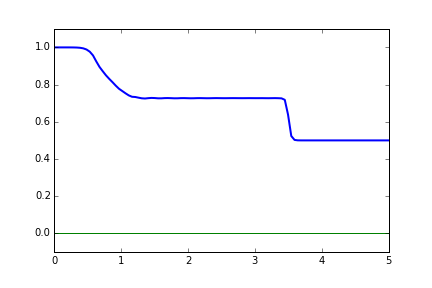
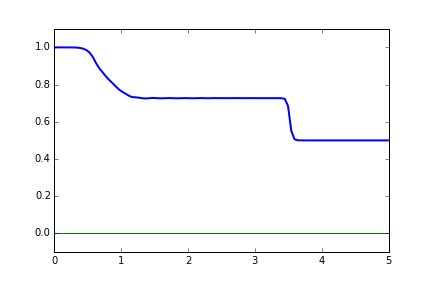
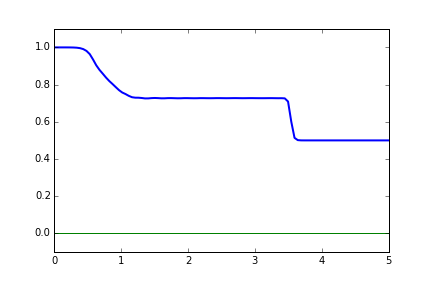
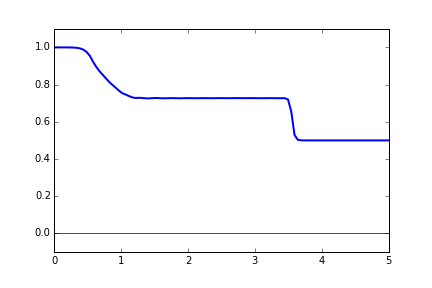
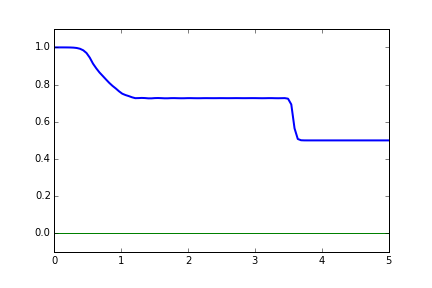
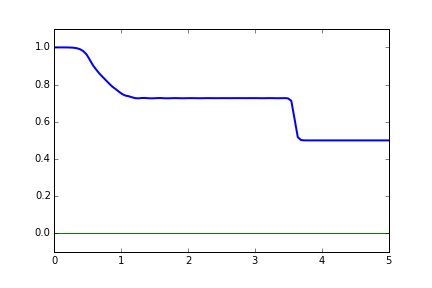
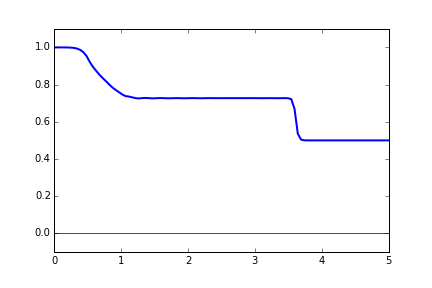
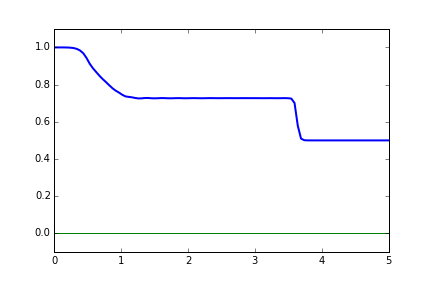
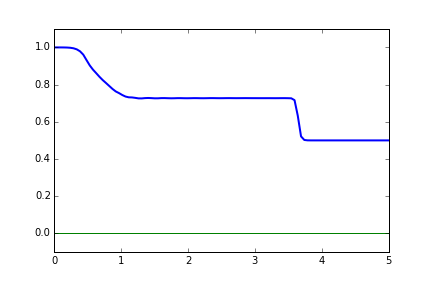
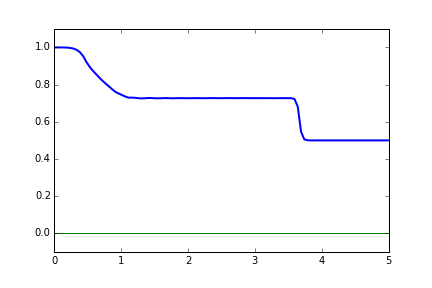
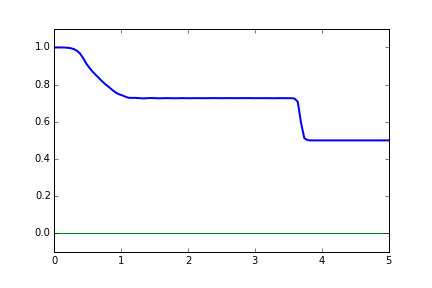
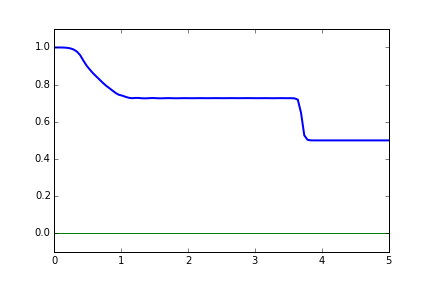
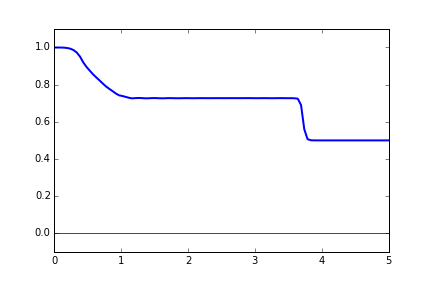
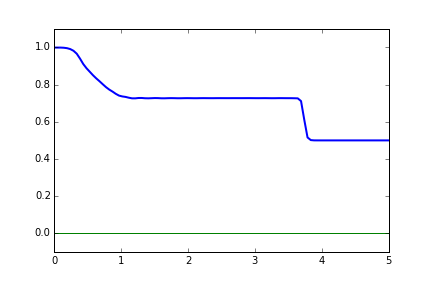
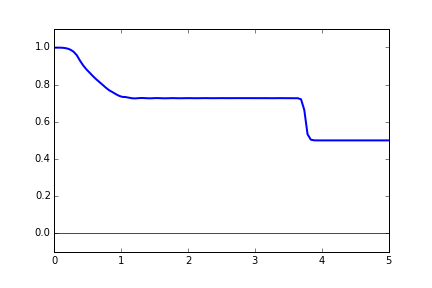
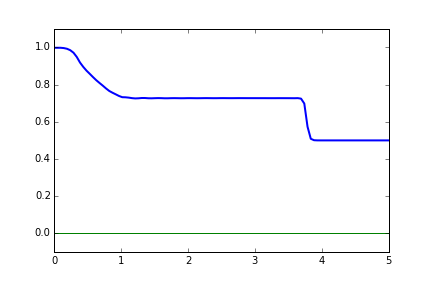

In [150]:
from matplotlib import animation
from JSAnimation import IPython_display

fig = plt.figure()
ax = plt.axes(xlim=(0, 5), ylim=(-0.1, 1.1))
line, = ax.plot([], [], lw=2)
plt.plot(x,d)
def init():
    line.set_data([], [])
    return line,

def animate(i):
    line.set_data(x, h[i,:]+d)
    return line,

animation.FuncAnimation(fig, animate, init_func=init,
                        frames=nt-1, interval=45)

# Implementación con RK4


$$U_{n+1} = U_n + \frac{1}{6}(m_1 + 2 m_2 + 2 m_3 + m_4)$$
donde 
\begin{align}
m_1 &= F(t_n,U_n)\Delta t\\
m_2 &= F(t_n + 0.5 \Delta t, U_n + 0.5m_1)\Delta t \\
m_3 &= F(t_n + 0.5 \Delta t, U_n + 0.5m_2)\Delta t \\
m_4 &= F(t_n + \Delta t, U_n +m_3)\Delta t
\end{align}

In [ ]:
def simulate_rk4(d,h,hu,bcs,dx,cfl,t0,nt):
    """
        Rutina principal que corre la simulacion
    """
    h1 = h*1.
    hu1 = hu*1.
    h2 = h*1.
    hu2 = hu*1.
    h3 = h*1.
    hu3= hu*1.

    t = np.zeros((nt,))
    for n in range(nt-1):     
        dt = setdt(h,hu,n,dx,cfl)
        
        t[n+1] = t[n] + dt

        d,h,hu = bcs(d,h,hu,n)    
        fp,fm,sc = fluxes_sources(d,h,hu,n)
        m1h = -dt/dx*(fm[0,1:] - fp[0,:-1]) + sc[0,1:-1]
        m1hu = -dt/dx*(fm[1,1:] - fp[1,:-1]) + sc[1,1:-1]
        h1[n,2:-2] = h[n,2:-2] + 0.5*m1h
        hu1[n,2:-2] = hu[n,2:-2] + 0.5*m1hu
        
        d,h1,hu1 = bcs(d,h1,hu1,n)            
        fp,fm,sc = fluxes_sources(d,h1,hu1,n)
        m2h = -dt/dx*(fm[0,1:] - fp[0,:-1]) + sc[0,1:-1]
        m2hu = -dt/dx*(fm[1,1:] - fp[1,:-1]) + sc[1,1:-1]
        h2[n,2:-2] = h[n,2:-2] + 0.5*m2h
        hu2[n,2:-2] = hu[n,2:-2] + 0.5*m2hu        
        
        h[n+1,2:-2] = h[n,2:-2] +0.5*(m1h+m2h)
        hu[n+1,2:-2] = hu[n,2:-2] +0.5*(m1hu+m2hu)
        print n
    return t,h,hu